In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import *
import seaborn as sns
import plotly.express as px
import time
import os
from collections import Counter
from math import pi
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

# Non-human evaluation results
## Overall Success rate 

In [2]:
def show_success_rate(csv_file_name, drop_puzzle_index = None):
    tem_df = pd.read_csv(csv_file_name)
    puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    result_dict = {}
    if drop_puzzle_index is not None and csv_file_name == 'human_result.csv':
        for item in drop_puzzle_index.items():
            drop_puzzle_name = item[0]
            for cur_puzzle_index, drop_puzzle_round in item[1]:
                remove_row = tem_df[(tem_df['puzzle_name'] == drop_puzzle_name) & (tem_df['puzzle_index'] == cur_puzzle_index) & (tem_df['round_index'] == drop_puzzle_round)]
                #print(len(tem_df))
                tem_df = tem_df.drop(remove_row.index)
                #print(len(tem_df))
                #print('----------------------------------------------------')
            

    for puzzle_name in puzzle_names:
        if puzzle_name == 'All':
            puzzle_df = tem_df.copy()
        else:
            puzzle_df = tem_df[tem_df['puzzle_name'] == puzzle_name]

        success_rates_level1 = []
        success_counts_level1 = 0
        total_counts_level1 = 0
        
        success_rates_level2_no_abduction = []
        success_counts_level2_no_abduction = 0
        total_counts_level2_no_abduction = 0
        
        success_rates_level2_abduction = []
        success_counts_level2_abduction = 0
        total_counts_level2_abduction = 0
        
        for round_index in range(1, 6):
            cur_round_puzzle_df = puzzle_df[puzzle_df['round_index'] == round_index]

            if csv_file_name != 'human_result.csv':
                level_1_df = cur_round_puzzle_df[cur_round_puzzle_df['puzzle_level'] == 1]
                level_1_success_count = len(level_1_df[level_1_df['solution_found'] == True])
                success_counts_level1 += level_1_success_count
                total_counts_level1 += len(level_1_df)
                
                level_2_no_abduction_df = cur_round_puzzle_df[(cur_round_puzzle_df['puzzle_level'] == 2) & (cur_round_puzzle_df['Do_abduction'] == False)]
                level_2_no_abduction_success_count = len(level_2_no_abduction_df[level_2_no_abduction_df['solution_found'] == True])
                success_counts_level2_no_abduction += level_2_no_abduction_success_count
                total_counts_level2_no_abduction += len(level_2_no_abduction_df)
            
            level_2_abduction_df = cur_round_puzzle_df[(cur_round_puzzle_df['puzzle_level'] == 2) & (cur_round_puzzle_df['Do_abduction'] == True)]
            level_2_abduction_success_count = len(level_2_abduction_df[level_2_abduction_df['solution_found'] == True])
            success_counts_level2_abduction += level_2_abduction_success_count
            total_counts_level2_abduction += len(level_2_abduction_df)
        
        # Calculate confidence intervals for each split
        if csv_file_name != 'human_result.csv':
            result_dict[puzzle_name] = [
                calculate_confidence_interval(success_counts_level1, total_counts_level1),
                calculate_confidence_interval(success_counts_level2_no_abduction, total_counts_level2_no_abduction),
                calculate_confidence_interval(success_counts_level2_abduction, total_counts_level2_abduction)
            ]
        else:
            result_dict[puzzle_name] = [
                calculate_confidence_interval(success_counts_level2_abduction, total_counts_level2_abduction)
            ]
            
    
    # Print results
    if csv_file_name != 'human_result.csv':
        split_names = ['Level1', 'Level2 no abduction', 'Level2 abduction']
    else:
        split_names = ['Level2 abduction']
    puzzle_types = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    
    for index, split_name in enumerate(split_names):
        print(f'% {split_name}')  # print split name
        table_row = ''
        for puzzle_type in puzzle_types:
            lower_bound = round(result_dict[puzzle_type][index][0] * 100, 2)
            upper_bound = round(result_dict[puzzle_type][index][2] * 100, 2)
            table_row += f'({lower_bound}\\%, {upper_bound}\\%) & '
        table_row = table_row.rstrip(' & ') + '\\\\'
        print(table_row)
        
def calculate_confidence_interval(success_counts, total_counts):
    lower_bounds, upper_bounds = proportion_confint(success_counts, total_counts, alpha=0.05, method='wilson')
    return [lower_bounds, np.mean(success_counts / total_counts), upper_bounds]

In [3]:
csv_file_name_list = ['Gemma7B_final_21.csv',
                      'Llama8B_final_21.csv',
                      'Llama70B_final_21.csv',
                      'gpt-3.5-turbo-0125_final_22.csv',
                      'gpt-4o-2024-05-13_final_22.csv',
                      'human_result.csv']
Puzzle_subsample_dict = { # the puzzle indices that are tested on human
    'Function_operator_puzzles':[3, 4, 5, 7, 8, 11, 13, 15, 16, 17],
    'Art_gallery_puzzles':[1, 2, 4, 7, 10, 12, 13, 15, 17, 20],
    'Reactor_puzzles':[1, 3, 5, 7, 9, 11, 12, 14, 15, 19]
    }

drop_puzzle_index = {  # no puzzle dropped only used in data preprocess
    'Function_operator_puzzles':[
                                ],
    'Art_gallery_puzzles':[
                         ],
    'Reactor_puzzles':[
                      ]
    }

In [4]:
for csv_file_name in csv_file_name_list:
    print(f'''----------------------------------{csv_file_name}-----------------------------------------''')
    show_success_rate(csv_file_name)

----------------------------------Gemma7B_final_21.csv-----------------------------------------
% Level1
(0.71\%, 3.84\%) & (0.0\%, 3.7\%) & (1.57\%, 9.84\%) & (0.18\%, 5.45\%)\\
% Level2 no abduction
(0.34\%, 2.9\%) & (0.0\%, 3.7\%) & (0.18\%, 5.45\%) & (0.55\%, 7.0\%)\\
% Level2 abduction
(0.06\%, 1.86\%) & (0.18\%, 5.45\%) & (0.0\%, 3.7\%) & (0.0\%, 3.7\%)\\
----------------------------------Llama8B_final_21.csv-----------------------------------------
% Level1
(7.09\%, 13.92\%) & (2.78\%, 12.48\%) & (12.51\%, 27.78\%) & (2.15\%, 11.18\%)\\
% Level2 no abduction
(2.55\%, 7.27\%) & (0.55\%, 7.0\%) & (4.81\%, 16.23\%) & (0.55\%, 7.0\%)\\
% Level2 abduction
(1.36\%, 5.17\%) & (0.18\%, 5.45\%) & (3.43\%, 13.75\%) & (0.0\%, 3.7\%)\\
----------------------------------Llama70B_final_21.csv-----------------------------------------
% Level1
(33.33\%, 44.29\%) & (28.18\%, 46.78\%) & (48.21\%, 67.2\%) & (14.17\%, 29.98\%)\\
% Level2 no abduction
(18.6\%, 28.09\%) & (22.78\%, 40.63\%) & (12.51\

## Repeat action count

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_duplicate_action_count(cur_df):
    total_duplicate_action_count = 0
    total_steps = 0
    for index, row in cur_df.iterrows():
        row_mem_list = row['All_memories_str'].split('<New Row>')
        for single_memory in row_mem_list:
            if single_memory.startswith('You can still try'):
                row_mem_list.remove(single_memory)
        counts = Counter(row_mem_list)
        cur_puzzle_duplicates = sum(count - 1 for item, count in counts.items() if count > 1)
        total_duplicate_action_count += cur_puzzle_duplicates
    return total_duplicate_action_count/len(cur_df) # average repeat action count per puzzle
    
def print_action_repeat_count(csv_file_name, drop_puzzle_index = None):
    tem_df = pd.read_csv(csv_file_name)
    puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']

    tem_df = pd.read_csv(csv_file_name)
    puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    result_dict = {}
    if drop_puzzle_index is not None and csv_file_name == 'human_result.csv':
        for item in drop_puzzle_index.items():
            drop_puzzle_name = item[0]
            for cur_puzzle_index, drop_puzzle_round in item[1]:
                remove_row = tem_df[(tem_df['puzzle_name'] == drop_puzzle_name) & (tem_df['puzzle_index'] == cur_puzzle_index) & (tem_df['round_index'] == drop_puzzle_round)]
                #print(len(tem_df))
                tem_df = tem_df.drop(remove_row.index)
                
    result_dict = {}

    for puzzle_name in puzzle_names:
        if puzzle_name == 'All':
            puzzle_df = tem_df.copy()
        else:
            puzzle_df = tem_df[tem_df['puzzle_name'] == puzzle_name]

        if csv_file_name != 'human_result.csv':
            level_1_df = puzzle_df[puzzle_df['puzzle_level'] == 1]

        
            level_2_no_abduction_df = puzzle_df[(puzzle_df['puzzle_level'] == 2) & (puzzle_df['Do_abduction'] == False)]

        
        level_2_abduction_df = puzzle_df[(puzzle_df['puzzle_level'] == 2) & (puzzle_df['Do_abduction'] == True)]
        if csv_file_name != 'human_result.csv':
            result_dict[puzzle_name] = [get_duplicate_action_count(level_1_df), get_duplicate_action_count(level_2_no_abduction_df), get_duplicate_action_count(level_2_abduction_df)]
        else:
            result_dict[puzzle_name] = [get_duplicate_action_count(level_2_abduction_df)]
    if csv_file_name != 'human_result.csv':
        split_names = ['Level1', 'Level2 no abduction', 'Level2 abduction']
    else:
        split_names = ['Level2 abduction']
    puzzle_types = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    print(csv_file_name)
    for index, split_name in enumerate(split_names):
        print(f'% {split_name}')  # 输出当前的 split 名称
        table_row = ''
        for puzzle_type in puzzle_types:
            print(f'''Current puzzle_type: {puzzle_type}''')
            #print(result_dict[puzzle_type])
            table_row += f'& {round(result_dict[puzzle_type][index],2)}'
        print(table_row)

In [6]:
for csv_file_name in csv_file_name_list:
    print(f'''----------------------------------{csv_file_name}-----------------------------------------''')
    print_action_repeat_count(csv_file_name)

----------------------------------Gemma7B_final_21.csv-----------------------------------------
Gemma7B_final_21.csv
% Level1
Current puzzle_type: All
Current puzzle_type: Function_operator_puzzles
Current puzzle_type: Art_gallery_puzzles
Current puzzle_type: Reactor_puzzles
& 8.28& 3.75& 11.49& 9.59
% Level2 no abduction
Current puzzle_type: All
Current puzzle_type: Function_operator_puzzles
Current puzzle_type: Art_gallery_puzzles
Current puzzle_type: Reactor_puzzles
& 7.27& 0.61& 11.73& 9.46
% Level2 abduction
Current puzzle_type: All
Current puzzle_type: Function_operator_puzzles
Current puzzle_type: Art_gallery_puzzles
Current puzzle_type: Reactor_puzzles
& 2.74& 6.33& 1.88& 0.02
----------------------------------Llama8B_final_21.csv-----------------------------------------
Llama8B_final_21.csv
% Level1
Current puzzle_type: All
Current puzzle_type: Function_operator_puzzles
Current puzzle_type: Art_gallery_puzzles
Current puzzle_type: Reactor_puzzles
& 2.39& 3.4& 1.2& 2.56
% Level

## Accumulate solved puzzle plot

In [7]:
def read_accumulate_success_count_data(csv_file_name, drop_puzzle_index = None, Puzzle_subsample_dict = None):
    df = pd.read_csv(csv_file_name)
    if Puzzle_subsample_dict is not None:
        sub_dfs = []
        for item in Puzzle_subsample_dict.items():
            puzzle_name = item[0]
            subsample_puzzle_list = item[1]
            for puzzle_index in subsample_puzzle_list:
                select_sub_df = df[(df['puzzle_name'] == puzzle_name) & (df['puzzle_index'] == puzzle_index)]
                sub_dfs.append(select_sub_df)
        df = pd.concat(sub_dfs)
    
    if drop_puzzle_index is not None:
        for item in drop_puzzle_index.items():
            drop_puzzle_name = item[0]
            for cur_puzzle_index, drop_puzzle_round in item[1]:
                remove_row = df[(df['puzzle_name'] == drop_puzzle_name) & (df['puzzle_index'] == cur_puzzle_index) & (df['round_index'] == drop_puzzle_round)]
                df = df.drop(remove_row.index)
    Level_1_count_all = []
    
    Level_2_count_abduction = []    # regular abduction, Agent can choose when to abduct
    
    Level_2_count_no_abduction = []

    for i in range(16):
        finish_count_df = df[(df['finish_step_count']==i)&(df['solution_found']==True)]
        Level_1_result_finish_count_df = finish_count_df[finish_count_df['puzzle_level']==1]
        Level_1_count_all.append(len(Level_1_result_finish_count_df))

        Level_2_result_finish_count_no_abduction = finish_count_df[(finish_count_df['puzzle_level']==2)& (finish_count_df['Do_abduction']==False)]   
        Level_2_count_no_abduction.append(len(Level_2_result_finish_count_no_abduction))

        Level_2_result_finish_count_abduction = finish_count_df[(finish_count_df['puzzle_level']==2)& (finish_count_df['Do_abduction']==True)]
        Level_2_count_abduction.append(len(Level_2_result_finish_count_abduction))

    return Level_1_count_all, Level_2_count_no_abduction, Level_2_count_abduction



def compare_accumulate_success_count_plot(csv_file_names: List[str], set_limit: bool = False, save_plot=None, drop_puzzle_index = None, Puzzle_subsample_dict = None):
    plt.rcParams.update({'font.size': 20})  
    root_folder = 'figures/'
    if not os.path.exists(root_folder):
        os.makedirs(root_folder)
    model_name_dict = {'Gemma7B_final_21.csv': 'Gemma 7B',
                       'Llama8B_final_21.csv': 'Llama3 8B',
                       'Llama70B_final_21.csv': 'Llama3 70B',
                       'gpt-3.5-turbo-0125_final_22.csv': 'GPT-3.5-turbo',
                       'gpt-4o-2024-05-13_final_22.csv': 'GPT_4o',
                       'human_result.csv': "Human"
                      }
    all_data = []
    for csv_file_name in csv_file_names:
        all_data.append(read_accumulate_success_count_data(csv_file_name, drop_puzzle_index = drop_puzzle_index, Puzzle_subsample_dict = Puzzle_subsample_dict))

    plot_name = [file_name for file_name in csv_file_names]
    fig, axs = plt.subplots(1, 3, figsize=(25, 8), sharey=set_limit)  
    axs = np.array([axs])  
    
    x = np.arange(1, 16)
    handles, labels = [], []
    puzzle_type = ['All', 'Function_operator', 'Art_gallery', 'Reactor']
    y = 0
    for z, label in enumerate(['Deduction Only', 'Baseline agent', 'IDEA agent']):  
        for i, plot in enumerate(plot_name):
            
            cumsum_data = np.cumsum(all_data[i][z])
            line, = axs[y][z].plot(x, cumsum_data[:-1], marker='o', label=f'{label} {plot}', linewidth=2)

            axs[y][z].set_xlabel('Interaction Step Count', fontsize=25)
            axs[y][z].set_ylabel('Cumulative Puzzle Success Count', fontsize=25)
            axs[y][z].set_title(f'{label}', fontsize=24)

            if y == 0 and z == 0:  
                handles.append(line)
                labels.append(f'{model_name_dict[plot]}')
            
    
    fig.legend(handles, labels, bbox_to_anchor=(0.905, 1.07), ncol=3, fontsize=20)

    if save_plot:
        plt.savefig(os.path.join(root_folder, save_plot) + '.pdf', format='pdf', bbox_inches='tight', dpi=300)

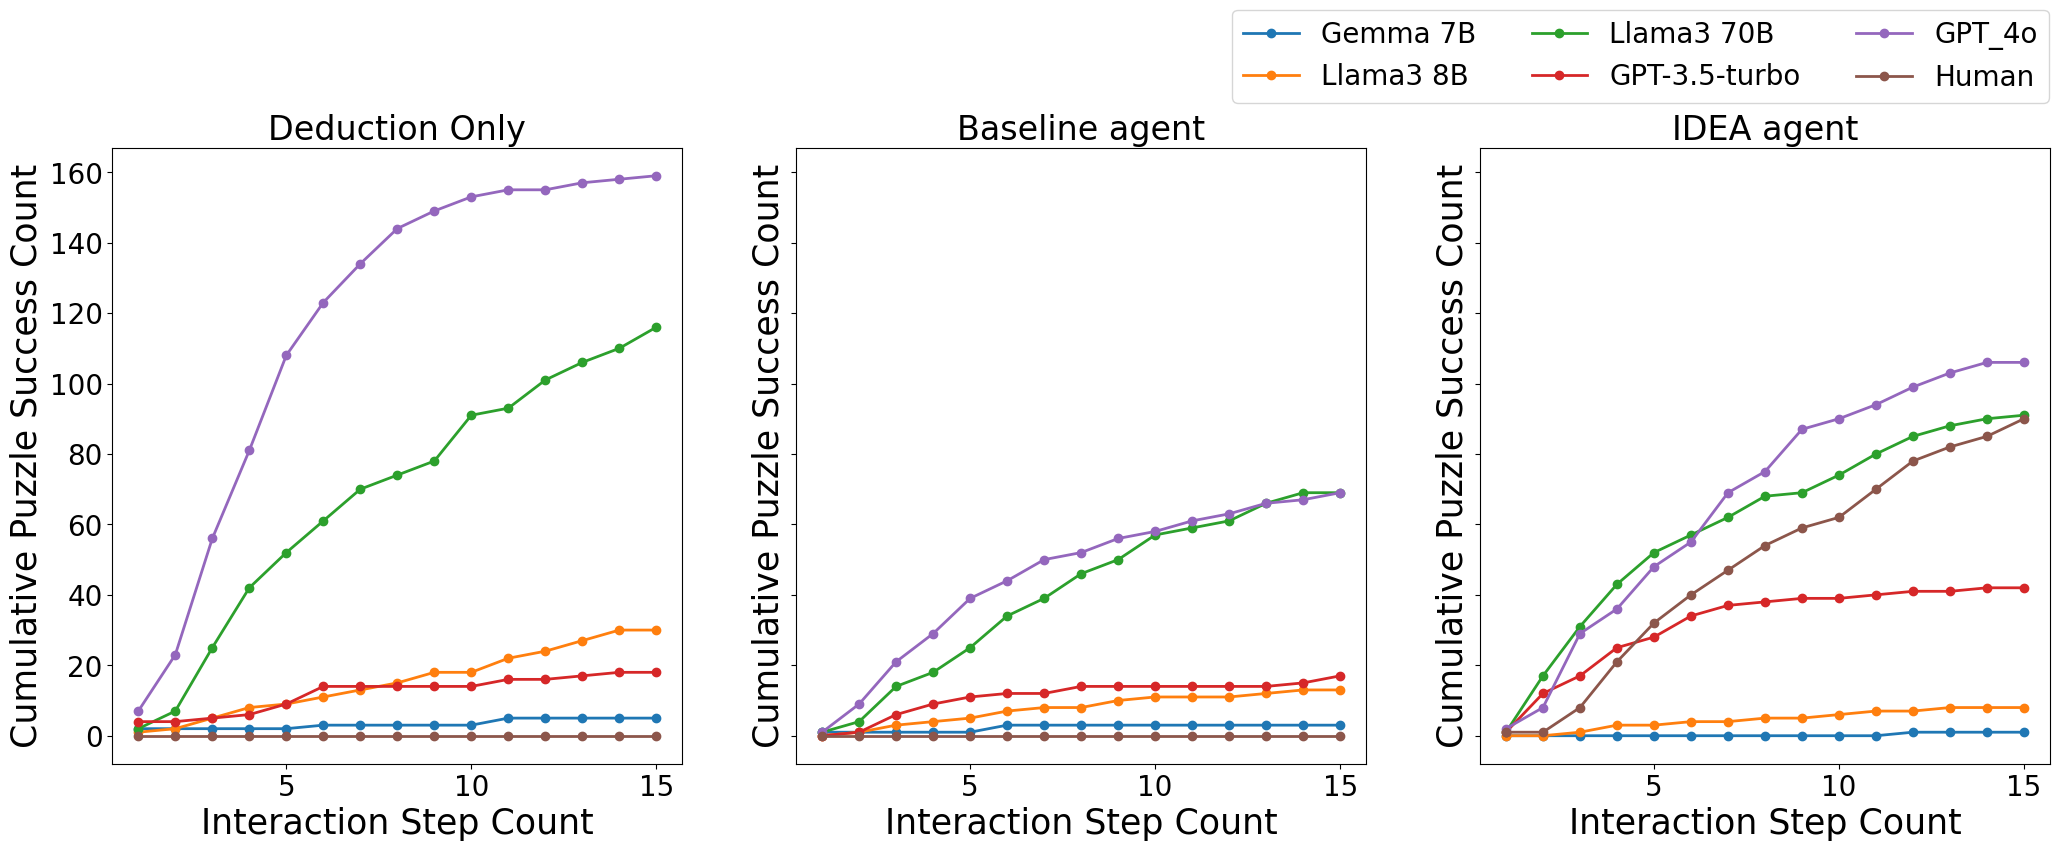

In [8]:
visualization_list = ['Gemma7B_final_21.csv',
                      'Llama8B_final_21.csv',
                      'Llama70B_final_21.csv',
                      'gpt-3.5-turbo-0125_final_22.csv',
                      'gpt-4o-2024-05-13_final_22.csv',
                      'human_result.csv'
                     ]
compare_accumulate_success_count_plot(visualization_list, set_limit = True, save_plot='Puzzle_solve_speed')

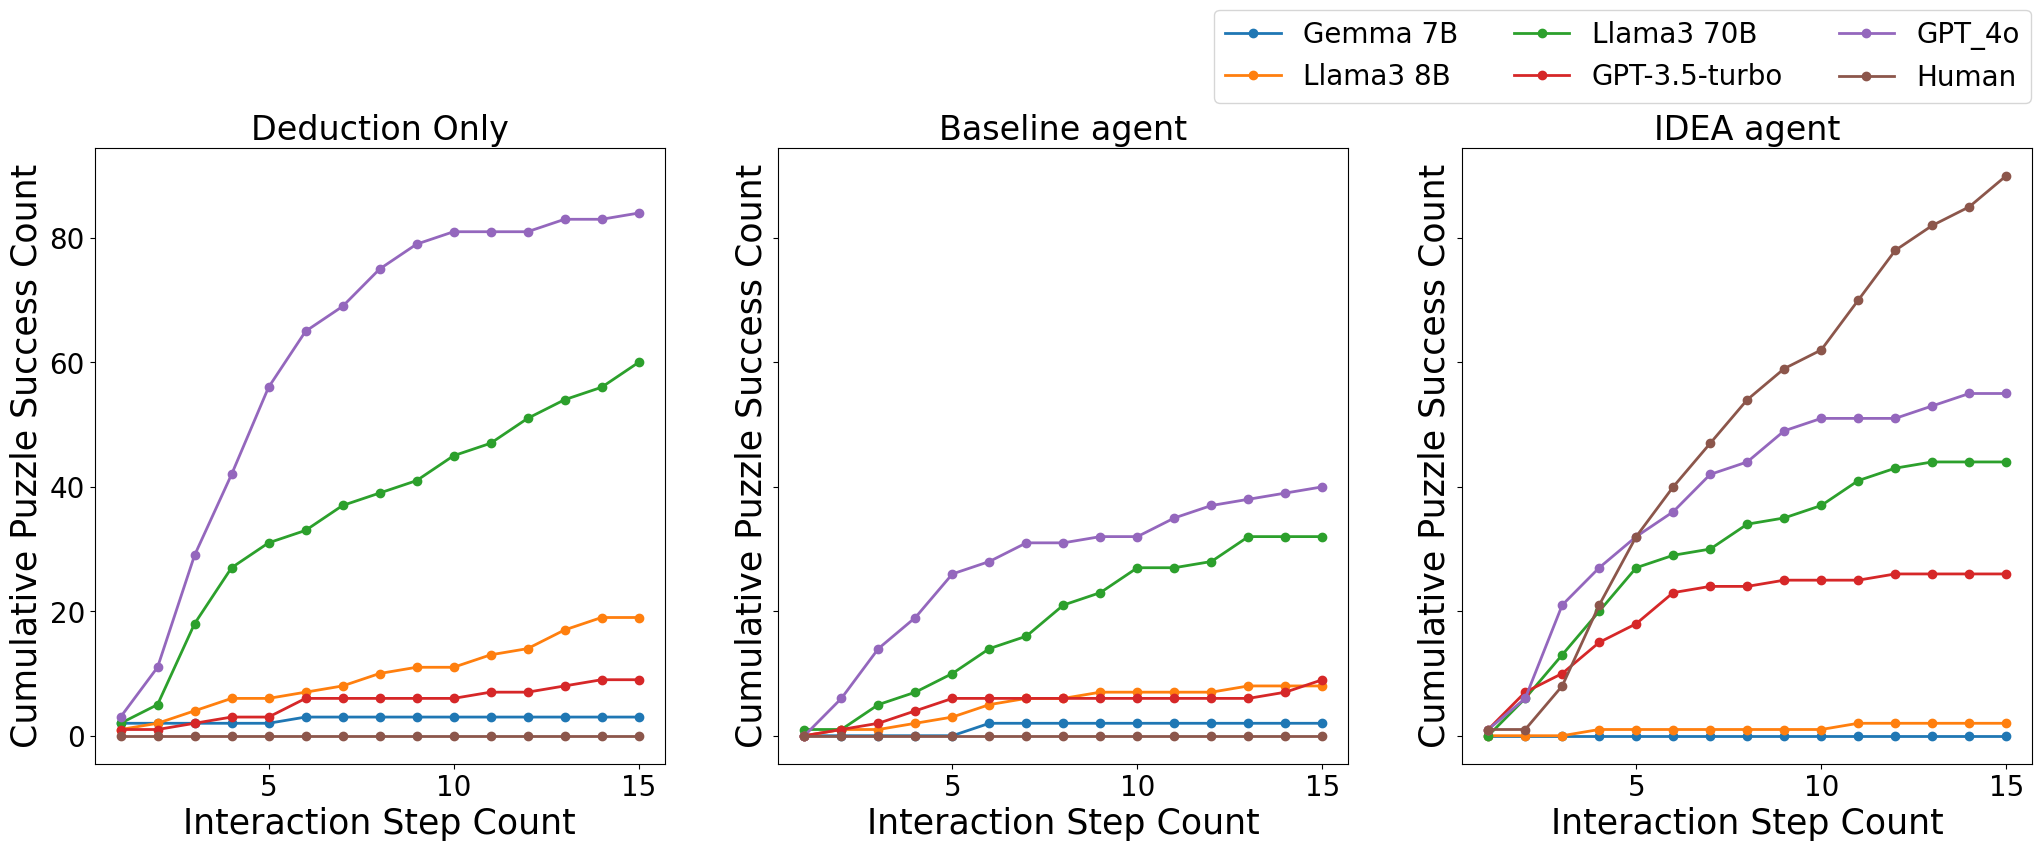

In [9]:
compare_accumulate_success_count_plot(visualization_list, Puzzle_subsample_dict = Puzzle_subsample_dict, set_limit = True)

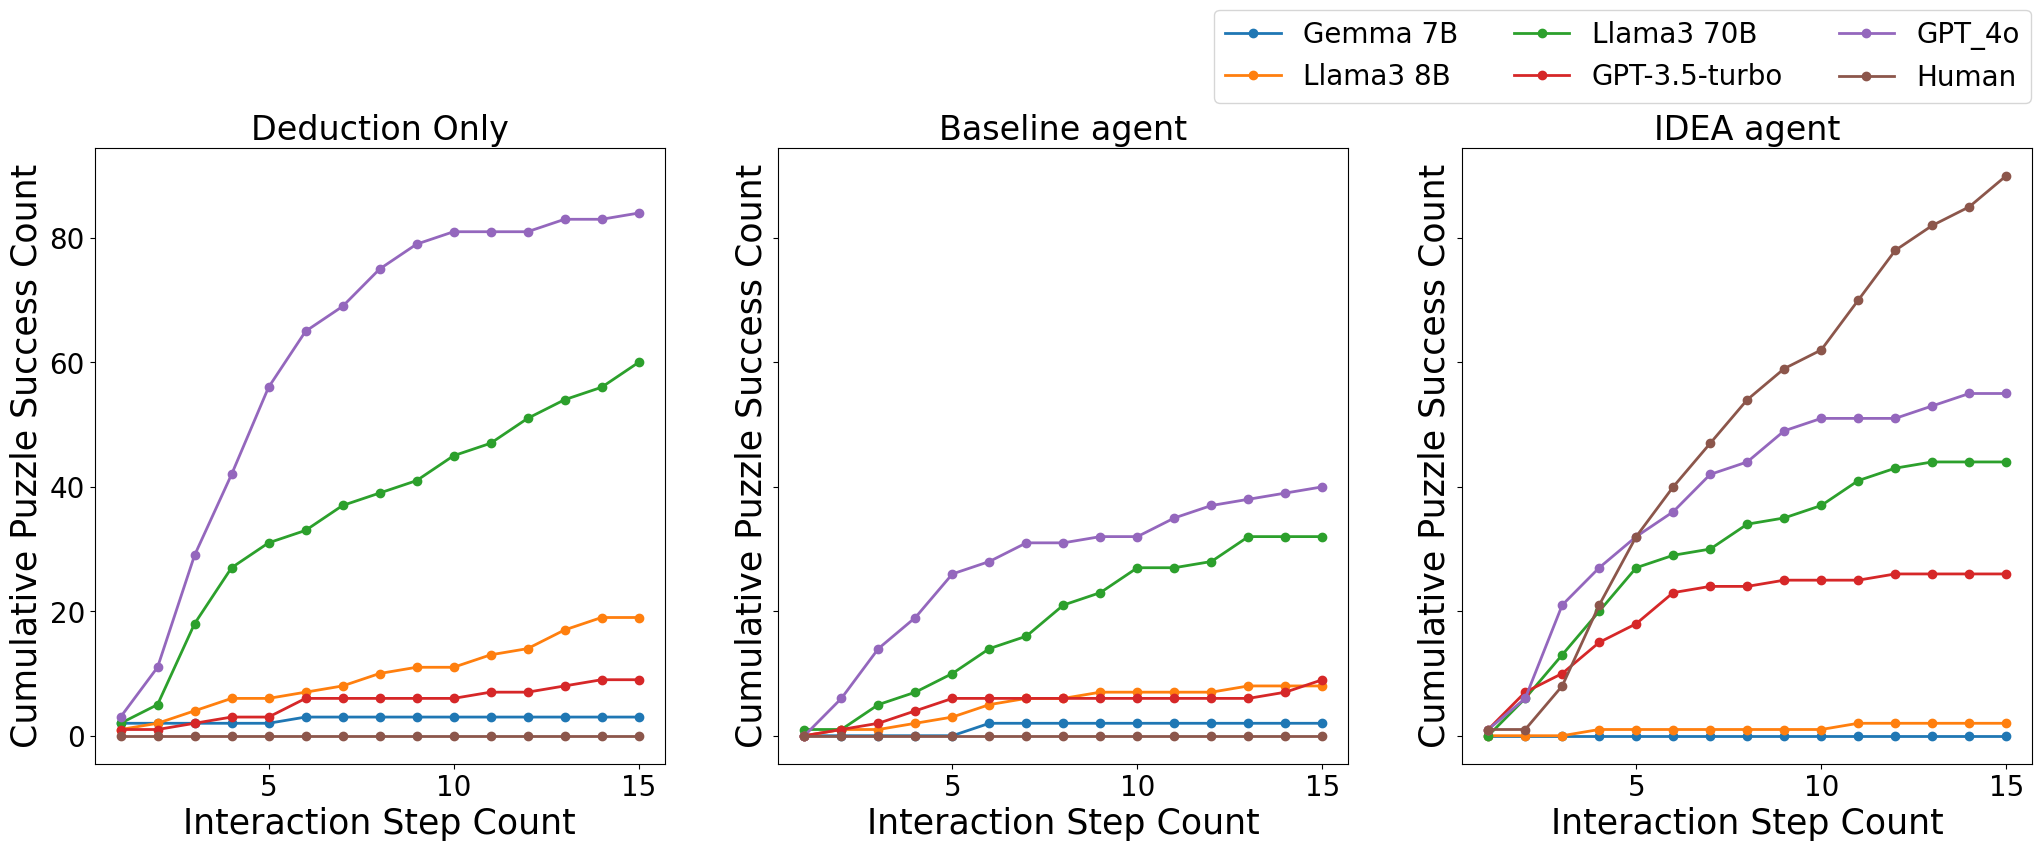

In [10]:
compare_accumulate_success_count_plot(visualization_list, Puzzle_subsample_dict = Puzzle_subsample_dict, set_limit = True)

# Human evaluation results

In [11]:
data_paths = ['data/evaluation_data/human_evaluation_test_0.csv',
              'data/evaluation_data/human_evaluation_test_1.csv',
              'data/evaluation_data/human_evaluation_test_2.csv'] # three evaluation data generated by co-authors
dfs = []
for path in data_paths:
    cur_df = pd.read_csv(path)
    dfs.append(cur_df)
human_evaluation_dfs = pd.concat(dfs)
gemma_7b_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'google_gemma-7b-it']
llama_8b_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'meta-llama_Meta-Llama-3-8B-Instruct']
llama_70b_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'meta-llama_Meta-Llama-3-70B-Instruct']
gpt_35_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'gpt-3.5-turbo-0125']
gpt_4o_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'gpt-4o-2024-05-13']
human_result = human_evaluation_dfs[human_evaluation_dfs['model_name'] == 'Human']
human_evaluation_data = {'Gemma 7B':gemma_7b_result,
          'Llama3 8B':llama_8b_result,
          'Llama3 70B':llama_70b_result,
          'GPT-3.5-turbo':gpt_35_result,
          'GPT_4o':gpt_4o_result,
          'human_result': human_result}

## induction effectiveness analysis

In [12]:
# average induction per puzzle
# average effectiveness induction per puzzle
#
# average induction per puzzle type
# average effectiveness induction per puzzle type
#
# total induction 
# total effectiveness induction 
#
def get_induction_data(drop_puzzle_index = None):
    induction_result = {}
    for model_name, evaluation_data in human_evaluation_data.items():
        if drop_puzzle_index is not None:
            for item in drop_puzzle_index.items():
                drop_puzzle_name = item[0]
                for cur_puzzle_index, drop_puzzle_round in item[1]:
                    remove_row = evaluation_data[(evaluation_data['puzzle_name'] == drop_puzzle_name) & (evaluation_data['puzzle_index'] == cur_puzzle_index) & (evaluation_data['round_index'] == drop_puzzle_round)]
                    if len(remove_row) > 1:
                        print(drop_puzzle_name, cur_puzzle_index, drop_puzzle_round)
                        return remove_row
                    evaluation_data = evaluation_data.drop(remove_row.index)
        puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
        cur_model_result = {}
        for puzzle_name in puzzle_names:
            if puzzle_name != 'All':
                cur_puzzle_df = evaluation_data[evaluation_data['puzzle_name'] == puzzle_name]
            else:
                cur_puzzle_df = evaluation_data
            total_induction_count = sum(cur_puzzle_df['total_action_count']) - len(cur_puzzle_df)
            total_effective_induction_count = sum(cur_puzzle_df['effective_induction_count'])
            effective_induction_per_puzzle = total_effective_induction_count/len(cur_puzzle_df)
            induction_per_puzzle = total_induction_count/len(cur_puzzle_df)
            if total_induction_count == 0:
                effective_induction_rate = None
            else:
                effective_induction_rate = round(total_effective_induction_count/total_induction_count,4)
                
            result_this_type_puzzle = {'total_induction_count':total_induction_count, 
                                       'total_effective_induction_count': total_effective_induction_count,
                                       'effective_induction_rate': effective_induction_rate,
                                       'effective_induction_per_puzzle': effective_induction_per_puzzle,
                                       'induction_per_puzzle': induction_per_puzzle
                                      }
            cur_model_result.update({puzzle_name: result_this_type_puzzle})
        
        induction_result.update({model_name: cur_model_result})
    return induction_result


def plot_induction(induction_result):
    rows = []
    for model_name, puzzles in induction_result.items():
        for puzzle_name, metrics in puzzles.items():
            row = {'Model': model_name, 'Puzzle_Type': puzzle_name}
            row.update(metrics)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Replace None with NaN for proper handling in plots
    df['effective_induction_rate'] = df['effective_induction_rate'].replace({None: pd.NA})
    df['effective_induction_rate'] = pd.to_numeric(df['effective_induction_rate'])
    
    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Plot Effective Induction Rate by Puzzle Type and Model
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Puzzle_Type', y='effective_induction_rate', hue='Model')
    plt.title('Effective Induction Rate by Puzzle Type and Model')
    plt.ylabel('Effective Induction Rate')
    plt.xlabel('Puzzle Type')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
    
    # Plot Induction per Puzzle by Puzzle Type and Model
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Puzzle_Type', y='induction_per_puzzle', hue='Model')
    plt.title('Induction per Puzzle by Puzzle Type and Model')
    plt.ylabel('Induction per Puzzle')
    plt.xlabel('Puzzle Type')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    # Plot Effective Induction per Puzzle by Puzzle Type and Model
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Puzzle_Type', y='effective_induction_per_puzzle', hue='Model')
    plt.title('Effective Induction per Puzzle by Puzzle Type and Model')
    plt.ylabel('Effective Induction per Puzzle')
    plt.xlabel('Puzzle Type')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

def plot_induction_diff(induction_result_no_drop, induction_result_drop):
    rows = []
    for result, label in zip([induction_result_no_drop, induction_result_drop], ['No Drop', 'Drop']):
        for model_name, puzzles in result.items():
            for puzzle_name, metrics in puzzles.items():
                row = {'Model': model_name, 'Puzzle_Type': puzzle_name, 'Condition': label}
                row.update(metrics)
                rows.append(row)
        
    df = pd.DataFrame(rows)
                    
    # Replace None with NaN for proper handling in plots
    df['effective_induction_rate'] = df['effective_induction_rate'].replace({None: pd.NA})
    df['effective_induction_rate'] = pd.to_numeric(df['effective_induction_rate'])
    
    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Plot Effective Induction Rate by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='effective_induction_rate',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Effective Induction Rate")
    g.fig.suptitle('Effective Induction Rate by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Plot Induction per Puzzle by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='induction_per_puzzle',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Induction per Puzzle")
    g.fig.suptitle('Induction per Puzzle by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Plot Effective Induction per Puzzle by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='effective_induction_per_puzzle',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Effective Induction per Puzzle")
    g.fig.suptitle('Effective Induction per Puzzle by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()

In [13]:
induction_result_no_drop = get_induction_data()

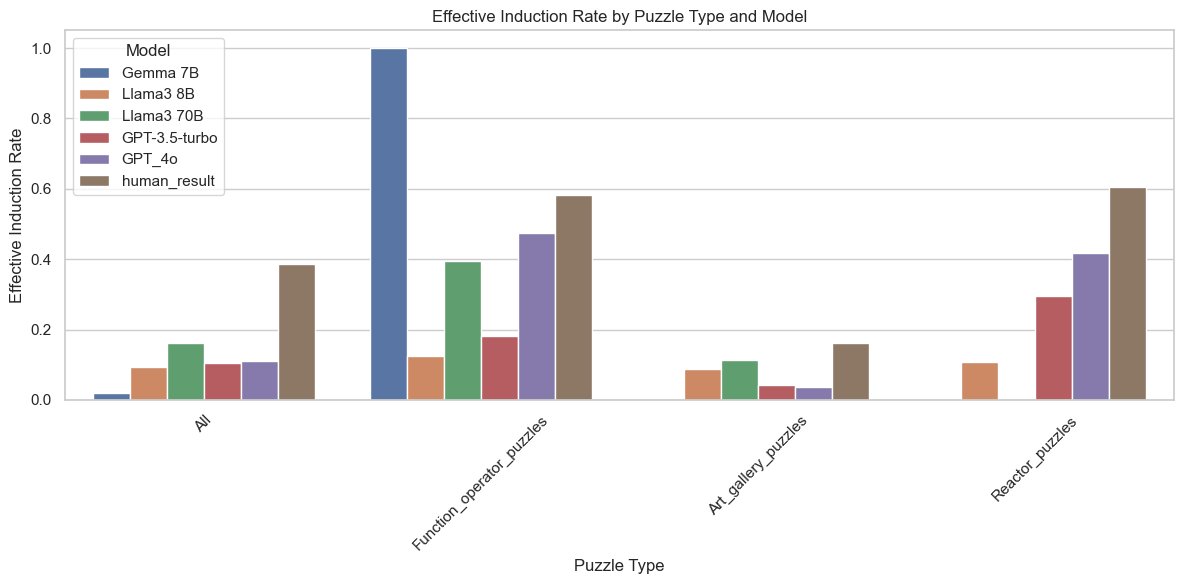

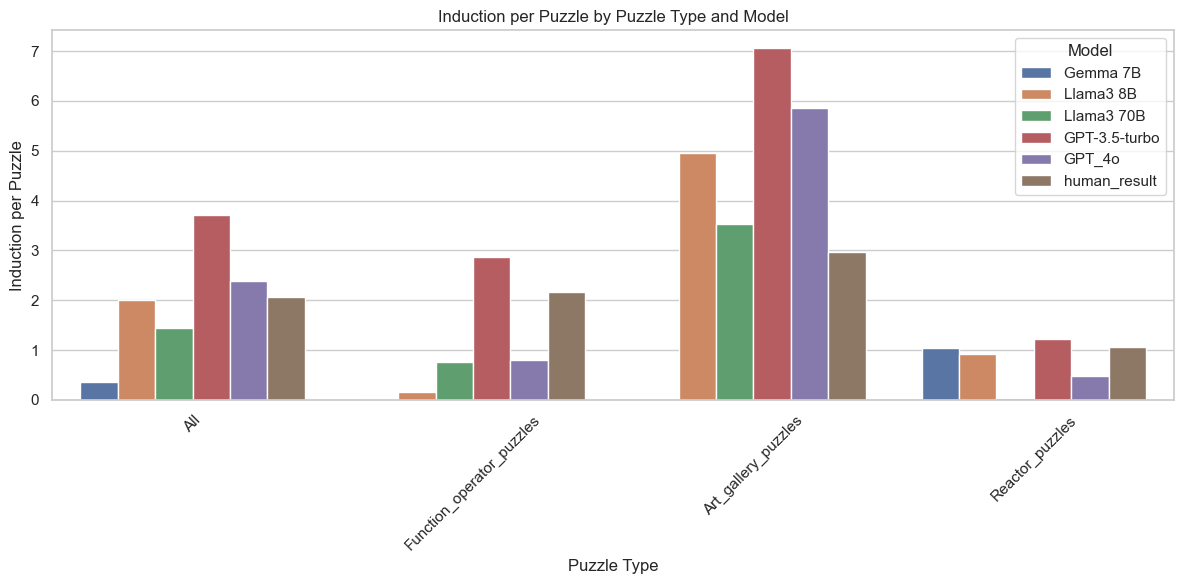

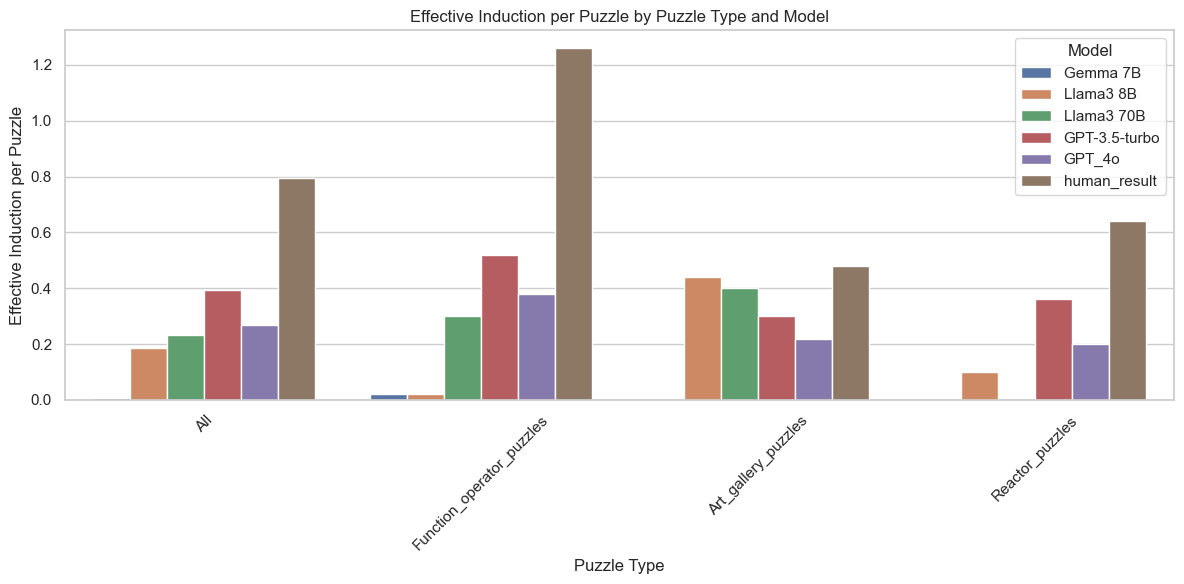

In [14]:
plot_induction(induction_result_no_drop)

## deduction effectiveness

In [15]:
def get_deduction_data(drop_puzzle_index = None):
    deduction_result = {}
    for model_name, evaluation_data in human_evaluation_data.items():
        if drop_puzzle_index is not None:
            for item in drop_puzzle_index.items():
                drop_puzzle_name = item[0]
                for cur_puzzle_index, drop_puzzle_round in item[1]:
                    remove_row = evaluation_data[(evaluation_data['puzzle_name'] == drop_puzzle_name) & (evaluation_data['puzzle_index'] == cur_puzzle_index) & (evaluation_data['round_index'] == drop_puzzle_round)]
                    if len(remove_row) > 1:
                        print(drop_puzzle_name, cur_puzzle_index, drop_puzzle_round)
                        return remove_row
                    evaluation_data = evaluation_data.drop(remove_row.index)
        puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
        cur_model_result = {}
        for puzzle_name in puzzle_names:
            if puzzle_name != 'All':
                cur_puzzle_df = evaluation_data[evaluation_data['puzzle_name'] == puzzle_name]
            else:
                cur_puzzle_df = evaluation_data
            total_induction_count = sum(cur_puzzle_df['total_action_count'])
            total_effective_induction_count = sum(cur_puzzle_df['deduction_plan_correctness_count'])
            effective_induction_per_puzzle = total_effective_induction_count/len(cur_puzzle_df)
            induction_per_puzzle = total_induction_count/len(cur_puzzle_df)
            if total_induction_count == 0:
                effective_induction_rate = None
            else:
                effective_induction_rate = round(total_effective_induction_count/total_induction_count,4)
                
            result_this_type_puzzle = {'total_deduction_count':total_induction_count, 
                                       'total_effective_deduction_count': total_effective_induction_count,
                                       'effective_deduction_rate': effective_induction_rate,
                                       'effective_deduction_per_puzzle': effective_induction_per_puzzle,
                                       'deduction_per_puzzle': induction_per_puzzle
                                      }
            cur_model_result.update({puzzle_name: result_this_type_puzzle})
        
        deduction_result.update({model_name: cur_model_result})
    return deduction_result

def plot_deduction(induction_result):
    rows = []
    for model_name, puzzles in induction_result.items():
        for puzzle_name, metrics in puzzles.items():
            row = {'Model': model_name, 'Puzzle_Type': puzzle_name}
            row.update(metrics)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Replace None with NaN for proper handling in plots
    df['effective_deduction_rate'] = df['effective_deduction_rate'].replace({None: pd.NA})
    df['effective_deduction_rate'] = pd.to_numeric(df['effective_deduction_rate'])
    
    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Plot Effective Induction Rate by Model and Puzzle Type
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Model', y='effective_deduction_rate', hue='Puzzle_Type')
    plt.title('Effective deduction Rate by Model and Puzzle Type')
    plt.ylabel('Effective deduction Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type')
    plt.tight_layout()
    plt.show()
    
    # Plot Induction per Puzzle by Model and Puzzle Type
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Model', y='deduction_per_puzzle', hue='Puzzle_Type')
    plt.title('deduction per Puzzle by Model and Puzzle Type')
    plt.ylabel('deduction per Puzzle')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type')
    plt.tight_layout()
    plt.show()
    
    # Plot Effective deduction per Puzzle by Model and Puzzle Type
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='Model', y='effective_deduction_per_puzzle', hue='Puzzle_Type')
    plt.title('Effective deduction per Puzzle by Model and Puzzle Type')
    plt.ylabel('Effective deduction per Puzzle')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type')
    plt.tight_layout()
    plt.show()

def plot_deduction_diff(induction_result_no_drop, induction_result_drop):
    rows = []
    for result, label in zip([induction_result_no_drop, induction_result_drop], ['No Drop', 'Drop']):
        for model_name, puzzles in result.items():
            for puzzle_name, metrics in puzzles.items():
                row = {'Model': model_name, 'Puzzle_Type': puzzle_name, 'Condition': label}
                row.update(metrics)
                rows.append(row)
        
    df = pd.DataFrame(rows)
    
    # Replace None with NaN for proper handling in plots
    df['effective_deduction_rate'] = df['effective_deduction_rate'].replace({None: pd.NA})
    df['effective_deduction_rate'] = pd.to_numeric(df['effective_deduction_rate'])
    
    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Plot Effective Induction Rate by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='effective_deduction_rate',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Effective Deduction Rate")
    g.fig.suptitle('Effective Deduction Rate by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Plot Induction per Puzzle by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='deduction_per_puzzle',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Deduction per Puzzle")
    g.fig.suptitle('Deduction per Puzzle by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Plot Effective Induction per Puzzle by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='effective_deduction_per_puzzle',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Effective Deduction per Puzzle")
    g.fig.suptitle('Effective Deduction per Puzzle by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()

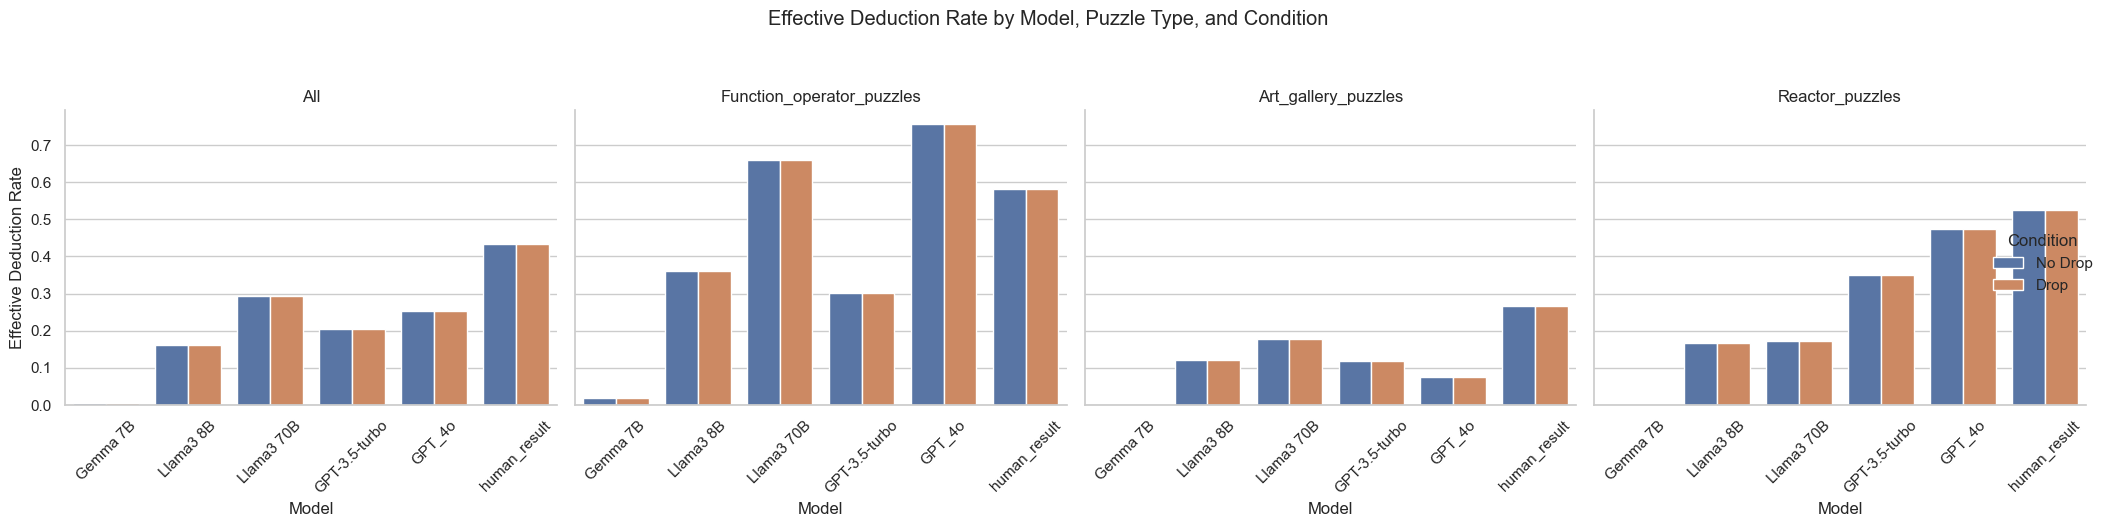

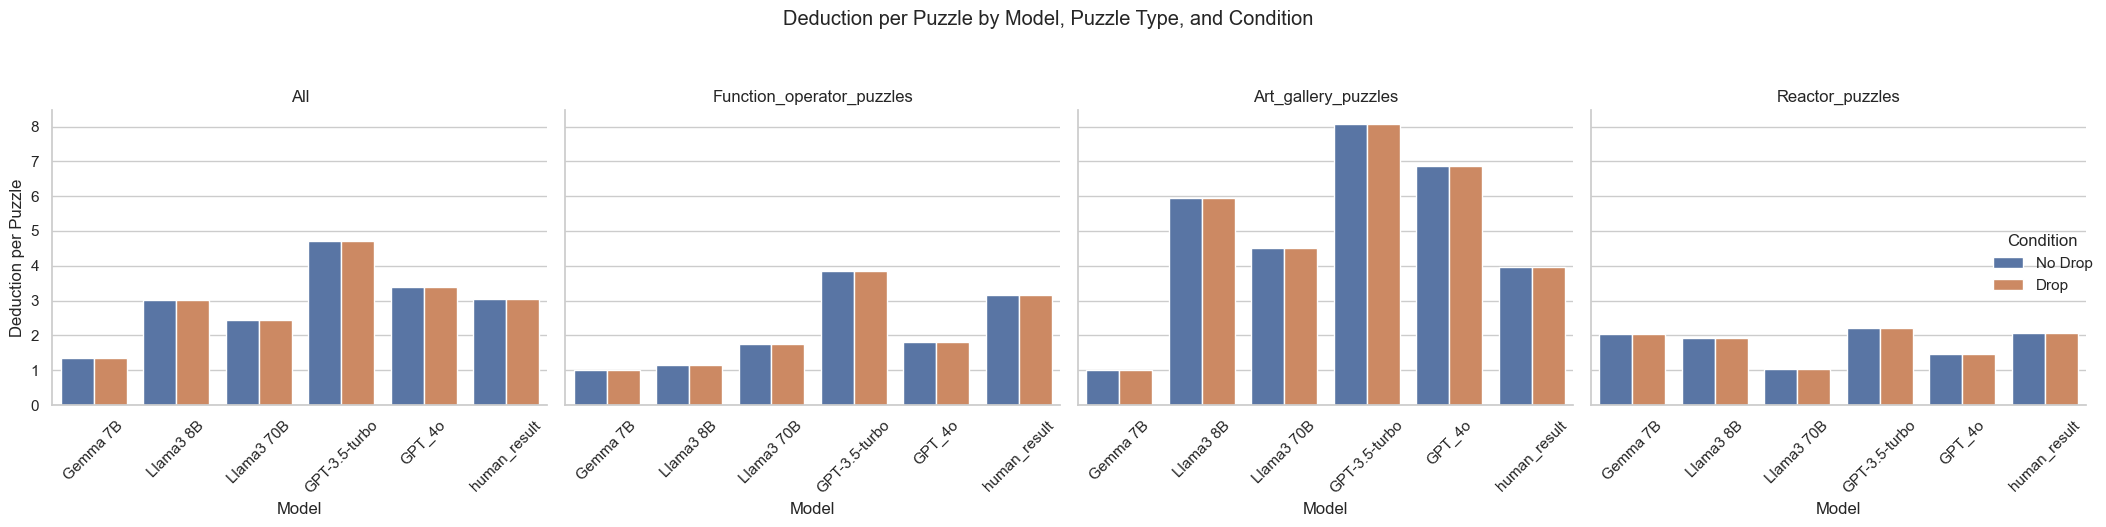

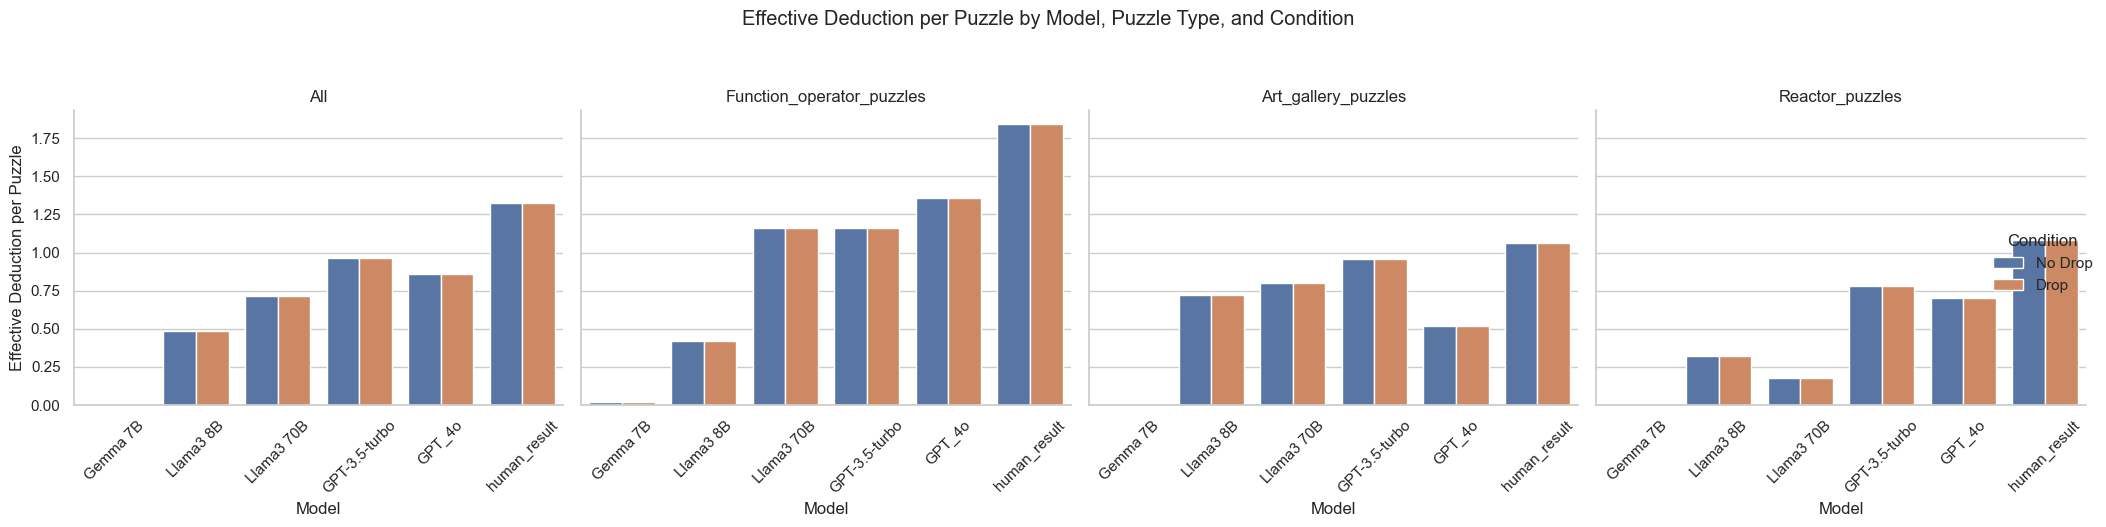

In [16]:
deduction_result_no_drop = get_deduction_data()

# Get data with dropping specified puzzles
deduction_result_drop = get_deduction_data(drop_puzzle_index=drop_puzzle_index)
                    
# Plot the comparison
plot_deduction_diff(deduction_result_no_drop, deduction_result_drop) # this only used when handling "outlier data" when preprocessing

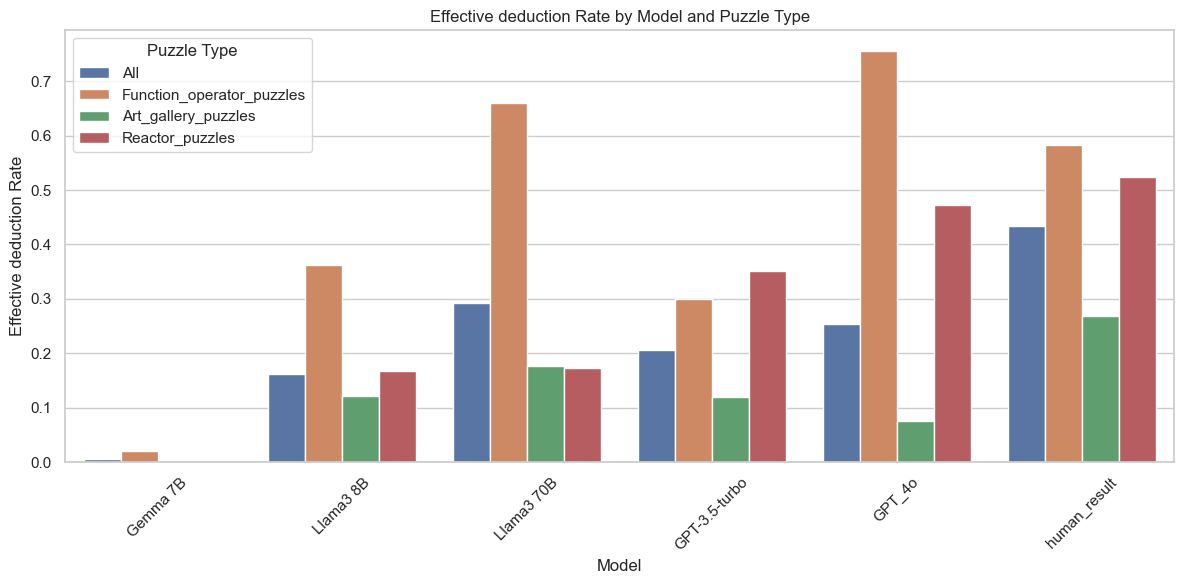

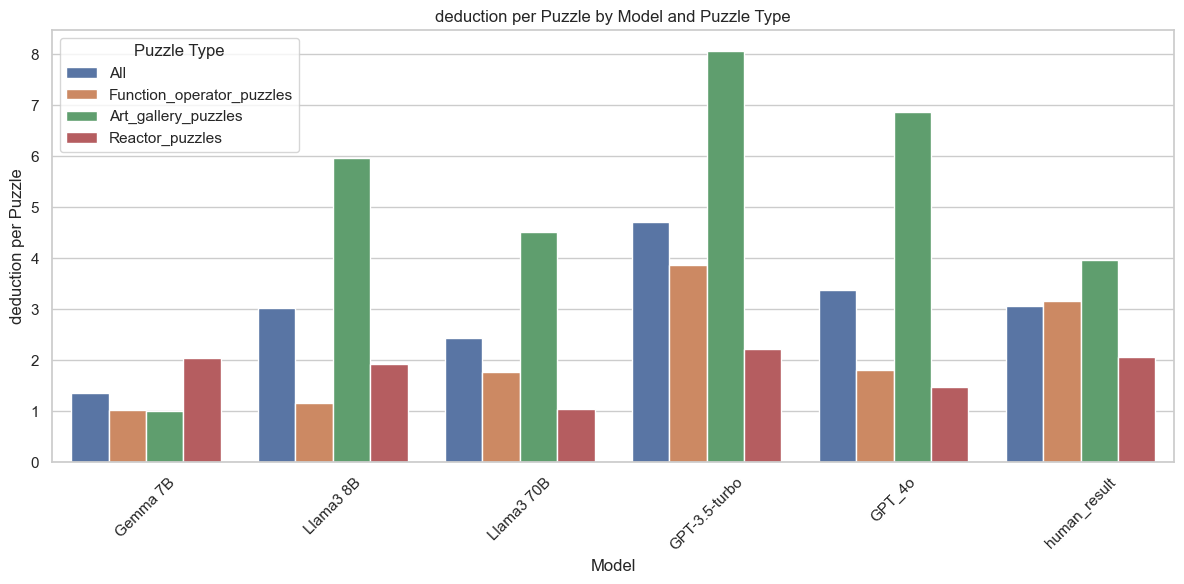

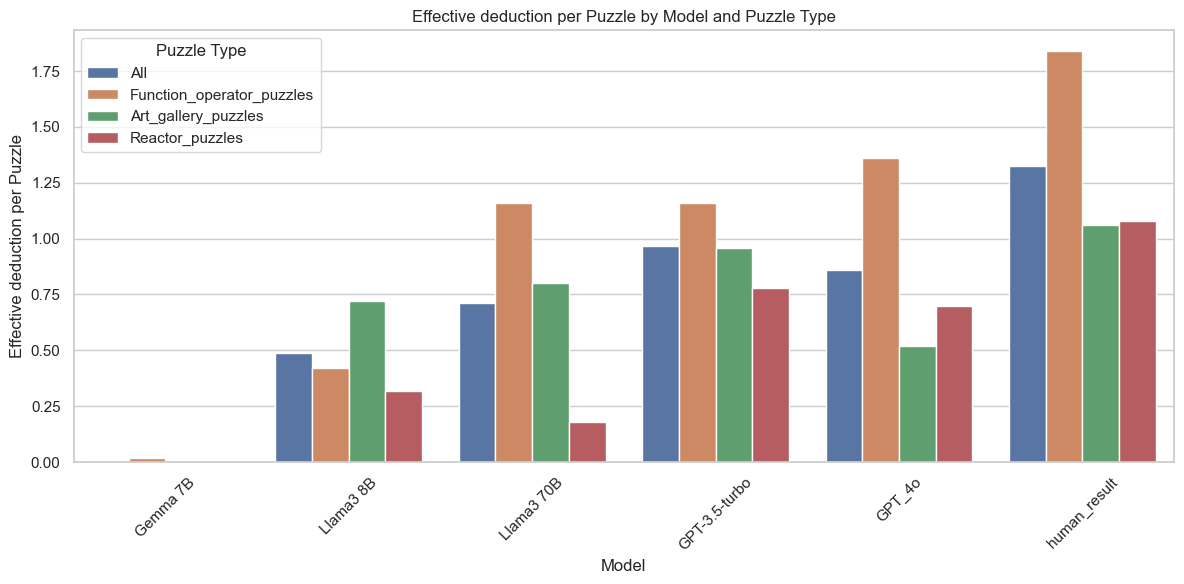

In [17]:
plot_deduction(deduction_result_drop)

## Abduction

In [18]:
def get_abduction_data(drop_puzzle_index = None):
    overall_result = {}
    for model_name, evaluation_data in human_evaluation_data.items():
        if drop_puzzle_index is not None:
            for item in drop_puzzle_index.items():
                drop_puzzle_name = item[0]
                for cur_puzzle_index, drop_puzzle_round in item[1]:
                    remove_row = evaluation_data[(evaluation_data['puzzle_name'] == drop_puzzle_name) & (evaluation_data['puzzle_index'] == cur_puzzle_index) & (evaluation_data['round_index'] == drop_puzzle_round)]
                    if len(remove_row) > 1:
                        print(drop_puzzle_name, cur_puzzle_index, drop_puzzle_round)
                    evaluation_data = evaluation_data.drop(remove_row.index)
        puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
        cur_model_result = {}
        for puzzle_name in puzzle_names:
            if puzzle_name != 'All':
                cur_puzzle_df = evaluation_data[evaluation_data['puzzle_name'] == puzzle_name]
            else:
                cur_puzzle_df = evaluation_data
            abduction_correct_count = sum(cur_puzzle_df['abduction_correctness'])
            abduction_correct_rate = abduction_correct_count/len(cur_puzzle_df)
            this_puzzle_result = {'abduction_correct_count':abduction_correct_count,
                                  'abduction_correct_rate':abduction_correct_rate}
            cur_model_result.update({puzzle_name:this_puzzle_result})
        overall_result.update({model_name: cur_model_result})  
    return overall_result
def plot_abduction_results(abduction_data):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Prepare the data
    rows = []
    for model_name, puzzles in abduction_data.items():
        for puzzle_name, metrics in puzzles.items():
            row = {
                'Model': model_name,
                'Puzzle_Type': puzzle_name,
                'abduction_correct_count': metrics['abduction_correct_count'],
                'abduction_correct_rate': metrics['abduction_correct_rate']
            }
            rows.append(row)
    df = pd.DataFrame(rows)

    # Set the seaborn style
    sns.set(style="whitegrid")

    # Plot Abduction Correct Rate by Model and Puzzle Type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='abduction_correct_rate', hue='Puzzle_Type')
    plt.title('Abduction Correct Rate by Model and Puzzle Type')
    plt.ylabel('Abduction Correct Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Abduction Correct Count by Model and Puzzle Type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='abduction_correct_count', hue='Puzzle_Type')
    plt.title('Abduction Correct Count by Model and Puzzle Type')
    plt.ylabel('Abduction Correct Count')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

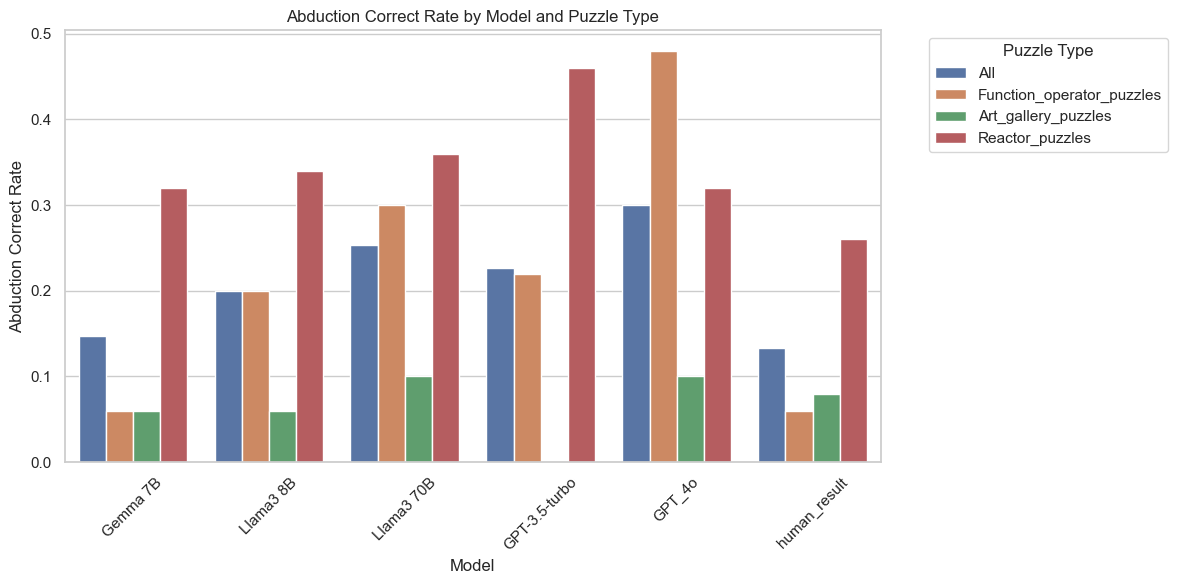

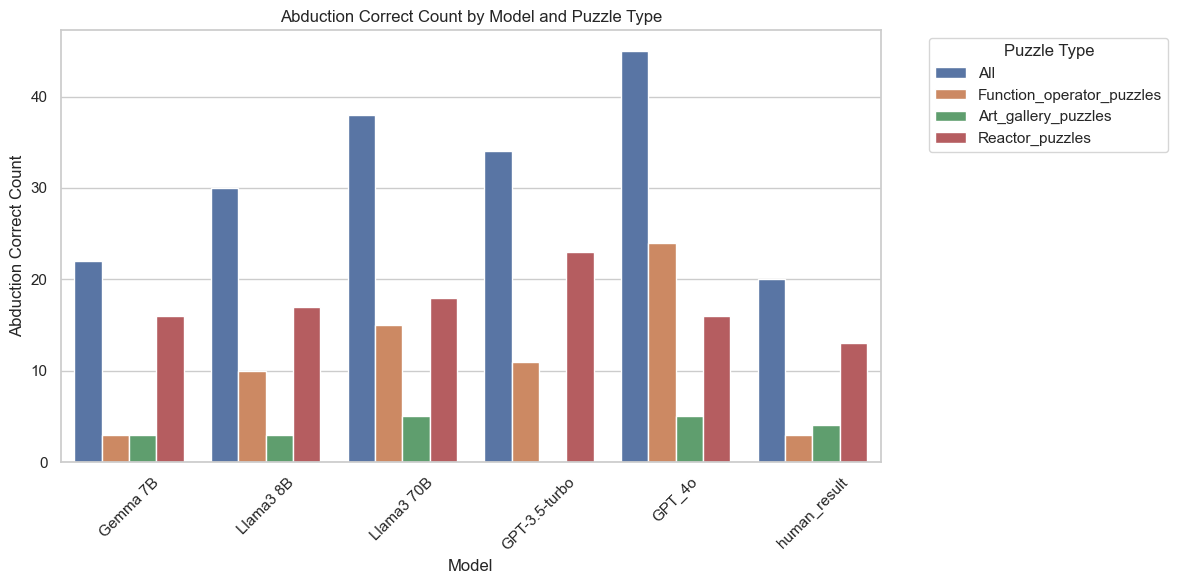

In [19]:
plot_abduction_results(get_abduction_data(drop_puzzle_index = drop_puzzle_index))

## Rule found analysis

In [20]:
def get_rule_found_data(drop_puzzle_index = None):
    overall_result = {}
    for model_name, evaluation_data in human_evaluation_data.items():
        if drop_puzzle_index is not None:
            for item in drop_puzzle_index.items():
                drop_puzzle_name = item[0]
                for cur_puzzle_index, drop_puzzle_round in item[1]:
                    remove_row = evaluation_data[(evaluation_data['puzzle_name'] == drop_puzzle_name) & (evaluation_data['puzzle_index'] == cur_puzzle_index) & (evaluation_data['round_index'] == drop_puzzle_round)]
                    if len(remove_row) > 1:
                        print(drop_puzzle_name, cur_puzzle_index, drop_puzzle_round)
                    evaluation_data = evaluation_data.drop(remove_row.index)
        puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
        cur_model_result = {}
        for puzzle_name in puzzle_names:
            if puzzle_name != 'All':
                cur_puzzle_df = evaluation_data[evaluation_data['puzzle_name'] == puzzle_name]
            else:
                cur_puzzle_df = evaluation_data
            rule_not_found_count = 0
            rule_found_with_abduction_count = 0
            rule_found_after_induction = 0
            total_induction_steps_to_rule = 0
            for index,row in cur_puzzle_df.iterrows():
                if row['steps_to_correct_rule'] == 0:
                    rule_found_with_abduction_count += 1
                elif row['steps_to_correct_rule'] == 9999:
                    rule_not_found_count += 1
                else:
                    rule_found_after_induction += 1
                    total_induction_steps_to_rule += row['steps_to_correct_rule']
             
            if rule_found_after_induction == 0:
                average_induction_step_to_rule = None
            else:
                average_induction_step_to_rule = round(total_induction_steps_to_rule/rule_found_after_induction,4) 
            this_puzzle_result = {'rule_not_found_count':rule_not_found_count,
                                  'rule_not_found_rate':round(rule_not_found_count/len(cur_puzzle_df),4),
                                  'rule_found_with_abduction_count':rule_found_with_abduction_count,
                                  'rule_found_with_abduction_rate':round(rule_found_with_abduction_count/len(cur_puzzle_df),4),
                                  'rule_found_after_induction':rule_found_after_induction,
                                  'rule_found_after_induction_rate':round(rule_found_after_induction/len(cur_puzzle_df),4),
                                  'average_induction_step_to_rule':average_induction_step_to_rule}
            cur_model_result.update({puzzle_name:this_puzzle_result})
        overall_result.update({model_name: cur_model_result})
    return overall_result

def plot_rule_found_data(rule_found_data):
    # Prepare the data
    rows = []
    for model_name, puzzles in rule_found_data.items():
        for puzzle_name, metrics in puzzles.items():
            row = {
                'Model': model_name,
                'Puzzle_Type': puzzle_name,
                'rule_not_found_count': metrics['rule_not_found_count'],
                'rule_not_found_rate': metrics['rule_not_found_rate'],
                'rule_found_with_abduction_count': metrics['rule_found_with_abduction_count'],
                'rule_found_with_abduction_rate': metrics['rule_found_with_abduction_rate'],
                'rule_found_after_induction': metrics['rule_found_after_induction'],
                'rule_found_after_induction_rate': metrics['rule_found_after_induction_rate'],
                'average_induction_step_to_rule': metrics['average_induction_step_to_rule']
            }
            rows.append(row)
    df = pd.DataFrame(rows)

    # Set the seaborn style
    sns.set(style="whitegrid")

    # Define the order of models and puzzle types for consistent plotting
    model_order = df['Model'].unique()
    puzzle_order = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']

    # Plot Rule Not Found Rate by Model and Puzzle Type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='rule_not_found_rate', hue='Puzzle_Type', order=model_order, hue_order=puzzle_order)
    plt.title('Rule Not Found Rate by Model and Puzzle Type')
    plt.ylabel('Rule Not Found Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Rule Found With Abduction Rate by Model and Puzzle Type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='rule_found_with_abduction_rate', hue='Puzzle_Type', order=model_order, hue_order=puzzle_order)
    plt.title('Rule Found With Abduction Rate by Model and Puzzle Type')
    plt.ylabel('Rule Found With Abduction Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Rule Found After Induction Rate by Model and Puzzle Type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='rule_found_after_induction_rate', hue='Puzzle_Type', order=model_order, hue_order=puzzle_order)
    plt.title('Rule Found After Induction Rate by Model and Puzzle Type')
    plt.ylabel('Rule Found After Induction Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Average Induction Steps to Rule by Model and Puzzle Type
    # Filter out rows where average_induction_step_to_rule is None
    df_steps = df.dropna(subset=['average_induction_step_to_rule'])
    if not df_steps.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_steps, x='Model', y='average_induction_step_to_rule', hue='Puzzle_Type', order=model_order, hue_order=puzzle_order)
        plt.title('Average Induction Steps to Rule by Model and Puzzle Type')
        plt.ylabel('Average Induction Steps to Rule')
        plt.xticks(rotation=45)
        plt.legend(title='Puzzle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for Average Induction Steps to Rule.")

def plot_rule_found_data_comparison(rule_found_data_no_drop, rule_found_data_drop):
    # Prepare the data
    rows = []
    for data, condition in zip([rule_found_data_no_drop, rule_found_data_drop], ['No Drop', 'Dropped']):
        for model_name, puzzles in data.items():
            for puzzle_name, metrics in puzzles.items():
                row = {
                    'Model': model_name,
                    'Puzzle_Type': puzzle_name,
                    'Condition': condition,
                    'rule_not_found_count': metrics['rule_not_found_count'],
                    'rule_not_found_rate': metrics['rule_not_found_rate'],
                    'rule_found_with_abduction_count': metrics['rule_found_with_abduction_count'],
                    'rule_found_with_abduction_rate': metrics['rule_found_with_abduction_rate'],
                    'rule_found_after_induction': metrics['rule_found_after_induction'],
                    'rule_found_after_induction_rate': metrics['rule_found_after_induction_rate'],
                    'average_induction_step_to_rule': metrics['average_induction_step_to_rule']
                }
                rows.append(row)
    df = pd.DataFrame(rows)

    # Set the seaborn style
    sns.set(style="whitegrid")

    # Define the order of models and puzzle types for consistent plotting
    model_order = df['Model'].unique()
    puzzle_order = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']

    # Plot Rule Not Found Rate by Model, Puzzle Type, and Condition
    g = sns.catplot(
        data=df,
        x='Model',
        y='rule_not_found_rate',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1,
        order=model_order,
        col_order=puzzle_order
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Rule Not Found Rate")
    g._legend.set_title('Condition')
    g.fig.suptitle('Rule Not Found Rate by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()

    # Plot Rule Found With Abduction Rate
    g = sns.catplot(
        data=df,
        x='Model',
        y='rule_found_with_abduction_rate',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1,
        order=model_order,
        col_order=puzzle_order
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Rule Found With Abduction Rate")
    g._legend.set_title('Condition')
    g.fig.suptitle('Rule Found With Abduction Rate by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()

    # Plot Rule Found After Induction Rate
    g = sns.catplot(
        data=df,
        x='Model',
        y='rule_found_after_induction_rate',
        hue='Condition',
        col='Puzzle_Type',
        kind='bar',
        height=5,
        aspect=1,
        order=model_order,
        col_order=puzzle_order
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Rule Found After Induction Rate")
    g._legend.set_title('Condition')
    g.fig.suptitle('Rule Found After Induction Rate by Model, Puzzle Type, and Condition', y=1.05)
    plt.tight_layout()
    plt.show()

    # Plot Average Induction Steps to Rule
    # Filter out rows where average_induction_step_to_rule is None
    df_steps = df.dropna(subset=['average_induction_step_to_rule'])
    if not df_steps.empty:
        g = sns.catplot(
            data=df_steps,
            x='Model',
            y='average_induction_step_to_rule',
            hue='Condition',
            col='Puzzle_Type',
            kind='bar',
            height=5,
            aspect=1,
            order=model_order,
            col_order=puzzle_order
        )
        g.set_titles("{col_name}")
        g.set_xticklabels(rotation=45)
        g.set_axis_labels("Model", "Average Induction Steps to Rule")
        g._legend.set_title('Condition')
        g.fig.suptitle('Average Induction Steps to Rule by Model, Puzzle Type, and Condition', y=1.05)
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for Average Induction Steps to Rule.")

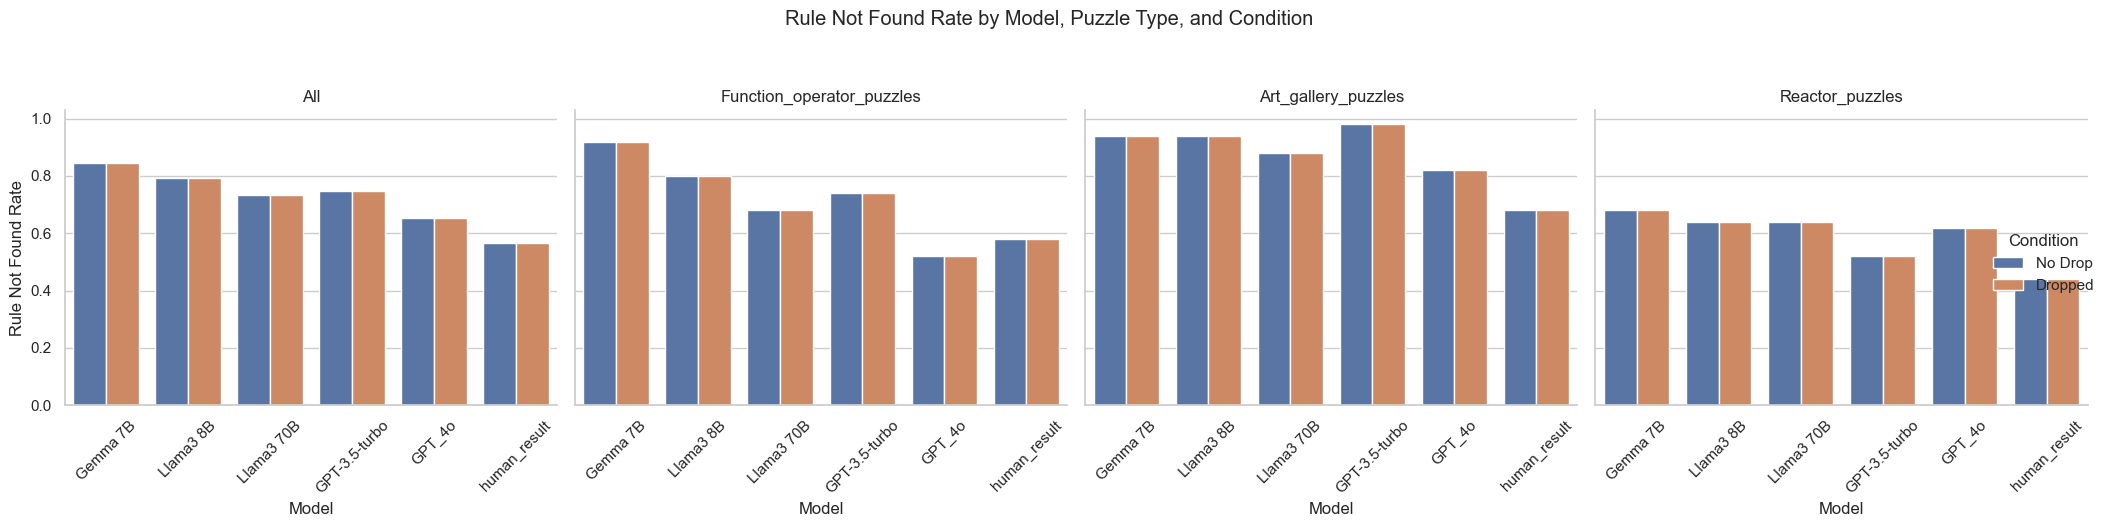

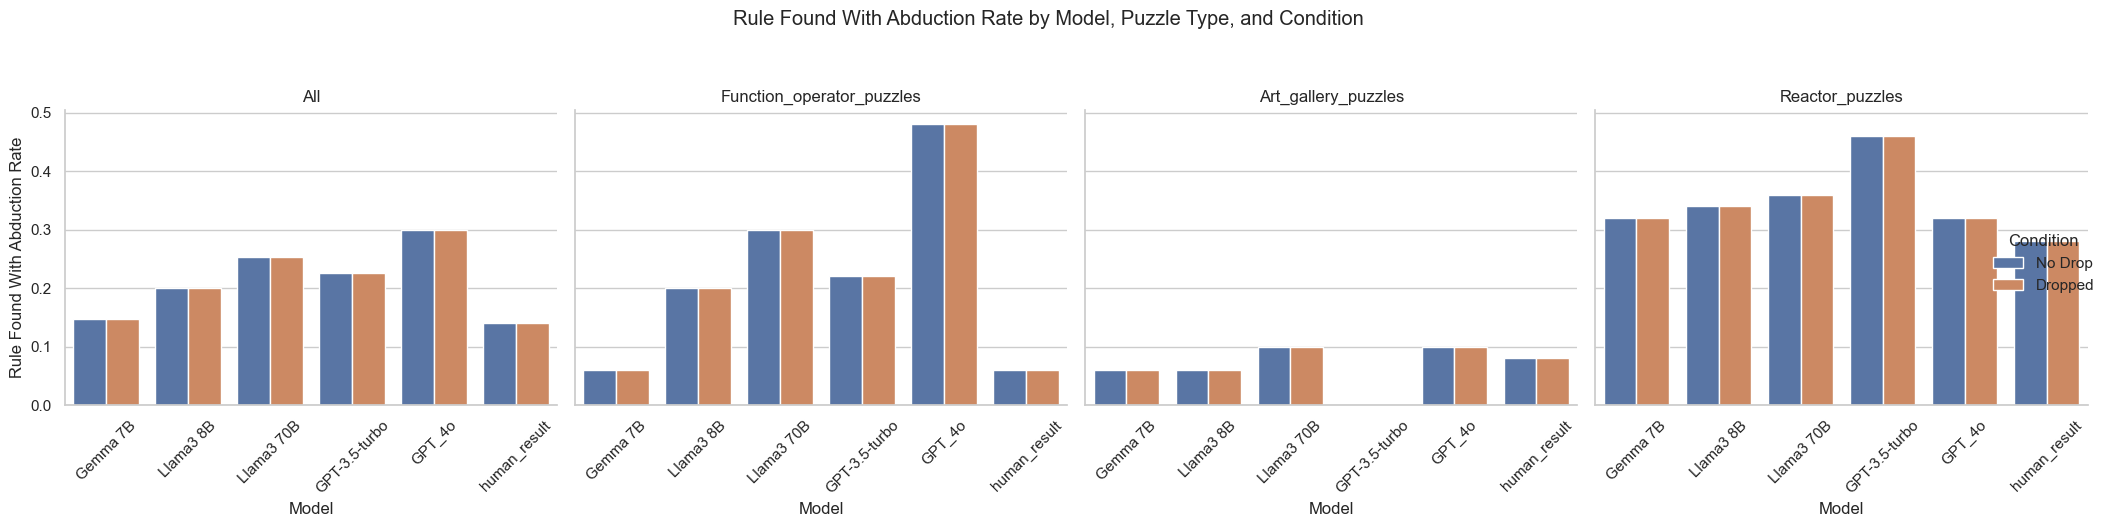

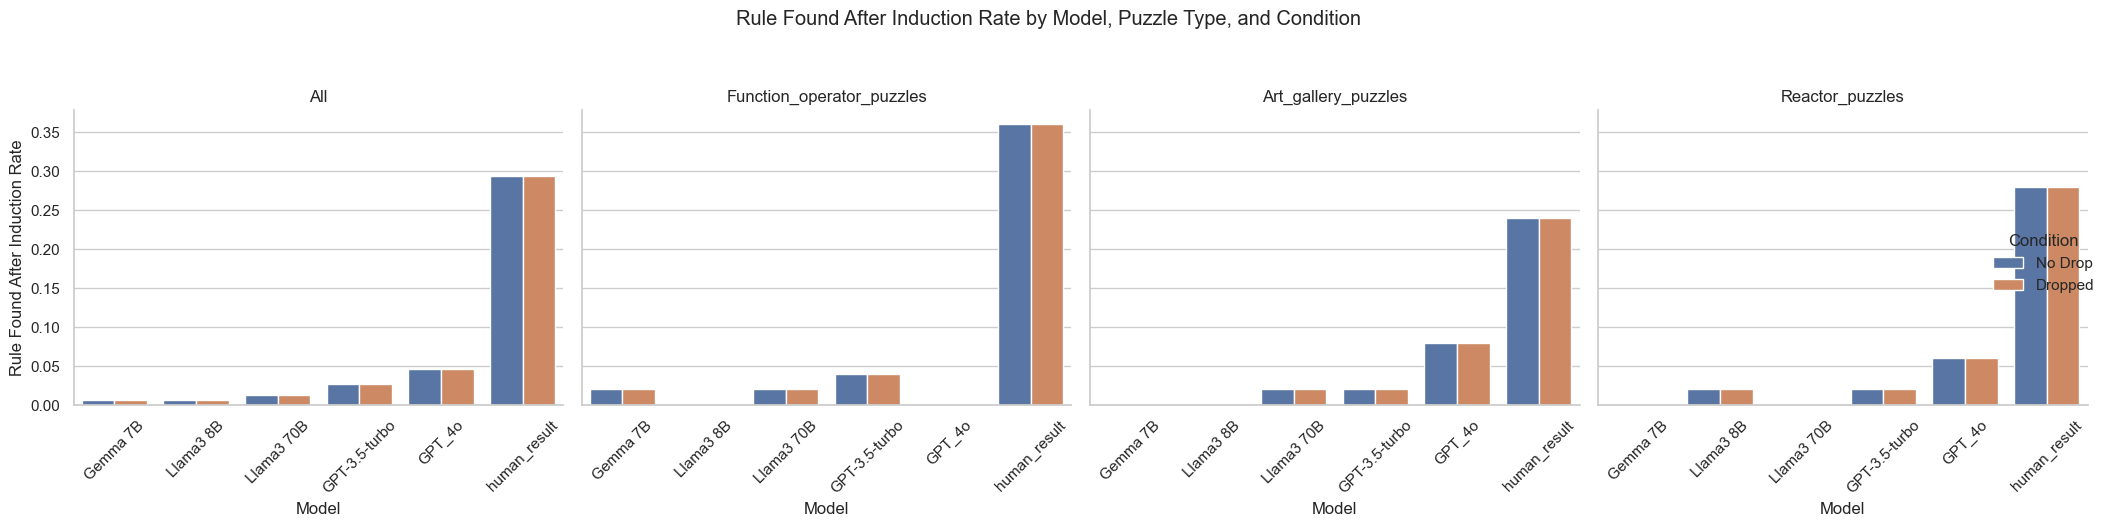

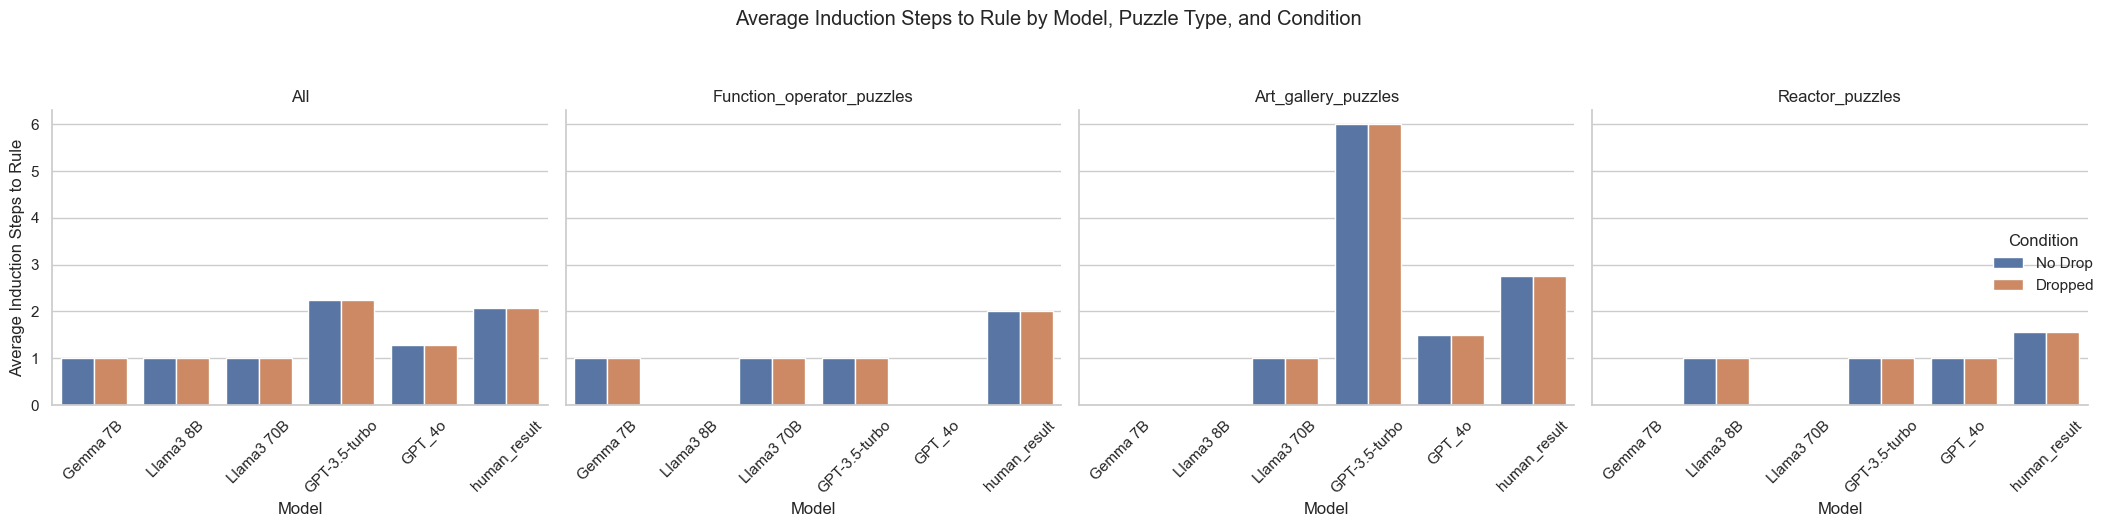

In [21]:
rule_data_with_drop = get_rule_found_data(drop_puzzle_index=drop_puzzle_index)
rule_data_without_drop = get_rule_found_data()
plot_rule_found_data_comparison(rule_data_without_drop, rule_data_with_drop)

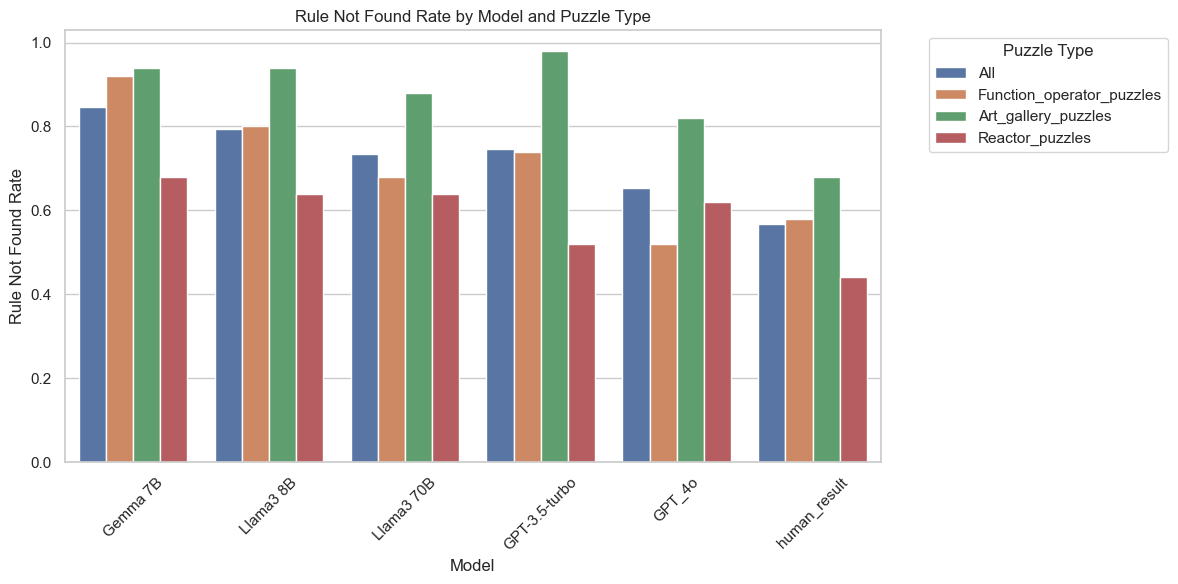

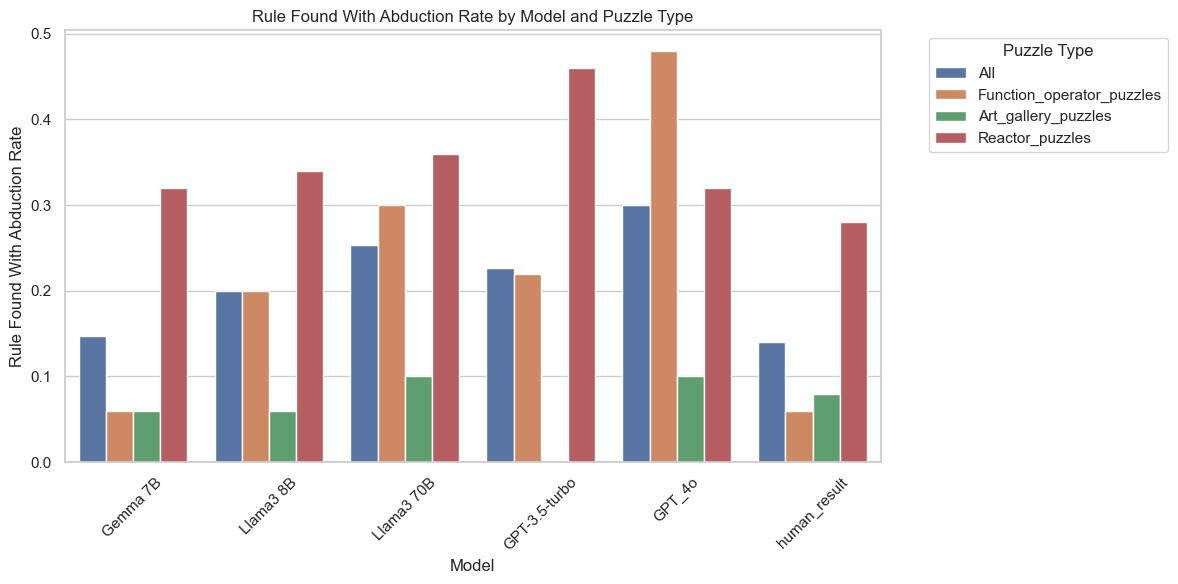

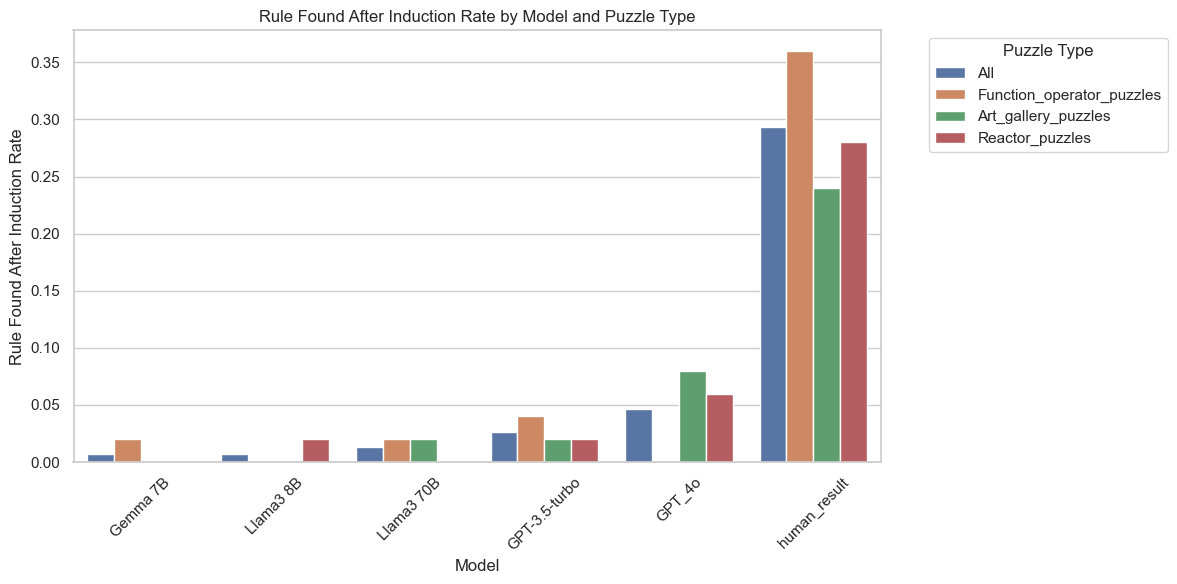

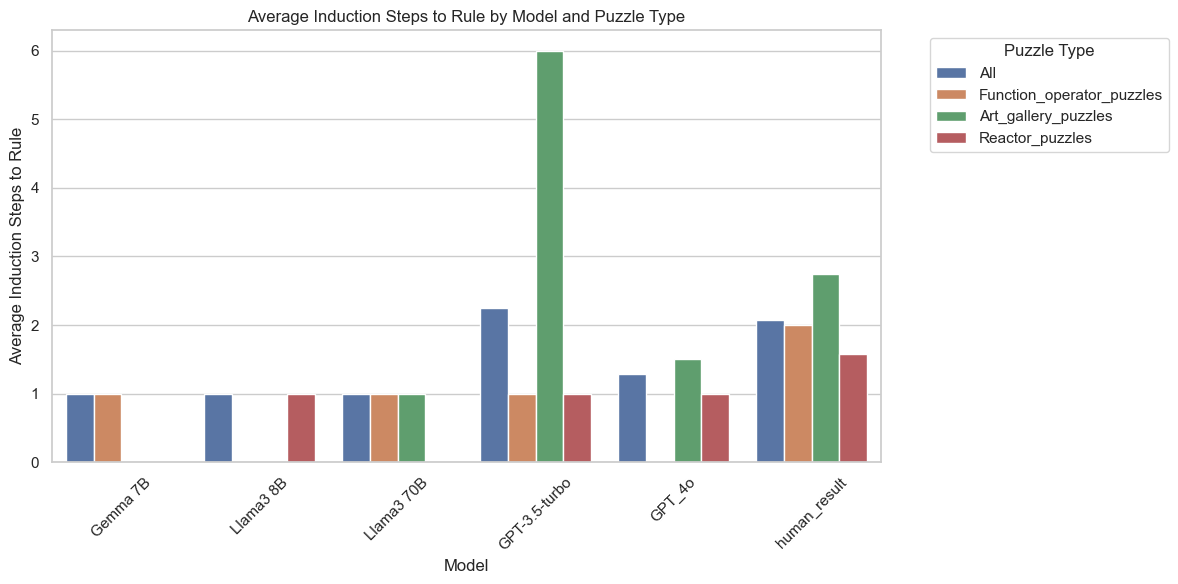

In [22]:
plot_rule_found_data(rule_data_with_drop)

In [23]:
import pandas as pd

def get_success_rate_data(drop_puzzle_index=None):
    overall_result = {}

    # Mapping of model names to their corresponding CSV files
    reference_dict = {
        'Gemma 7B': 'Gemma7B_final_21.csv',
        'Llama3 8B': 'Llama8B_final_21.csv',
        'Llama3 70B': 'Llama70B_final_21.csv',
        'GPT-3.5-turbo': 'gpt-3.5-turbo-0125_final_22.csv',
        'GPT_4o': 'gpt-4o-2024-05-13_final_22.csv',
        'human_result': 'human_result.csv'
    }

    # Load all solution_found DataFrames once
    model_solution_found_data = {}
    for model_name, file_path in reference_dict.items():
        model_solution_found_data[model_name] = pd.read_csv(file_path)

    for model_name, evaluation_data in human_evaluation_data.items():
        evaluation_data = evaluation_data.copy()

        # Get the solution_found DataFrame for the current model
        solution_df = model_solution_found_data[model_name]

        # Merge evaluation_data with solution_df on ['puzzle_name', 'puzzle_index', 'round_index']
        merged_data = pd.merge(
            evaluation_data,
            solution_df[['puzzle_name', 'puzzle_index', 'round_index', 'solution_found']],
            on=['puzzle_name', 'puzzle_index', 'round_index'],
            how='left'
        )

        # Apply drop_puzzle_index if necessary
        if drop_puzzle_index is not None:
            for drop_puzzle_name, indices in drop_puzzle_index.items():
                for cur_puzzle_index, drop_puzzle_round in indices:
                    remove_row = merged_data[
                        (merged_data['puzzle_name'] == drop_puzzle_name) &
                        (merged_data['puzzle_index'] == cur_puzzle_index) &
                        (merged_data['round_index'] == drop_puzzle_round)
                    ]
                    merged_data = merged_data.drop(remove_row.index)

        puzzle_names = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
        cur_model_result = {}

        for puzzle in puzzle_names:
            if puzzle != 'All':
                cur_puzzle_df = merged_data[merged_data['puzzle_name'] == puzzle]
            else:
                cur_puzzle_df = merged_data

            total_cases = len(cur_puzzle_df)
            if total_cases == 0:
                # Skip if no data is available for this puzzle type
                continue

            # Categorize data based on 'steps_to_correct_rule'
            rule_not_found = cur_puzzle_df[cur_puzzle_df['steps_to_correct_rule'] == 9999]
            rule_found_with_abduction = cur_puzzle_df[cur_puzzle_df['steps_to_correct_rule'] == 0]
            rule_found_after_induction = cur_puzzle_df[
                (cur_puzzle_df['steps_to_correct_rule'] != 0) &
                (cur_puzzle_df['steps_to_correct_rule'] != 9999)
            ]

            # Compute counts and success rates
            def compute_success_rate(group):
                count = len(group)
                if count == 0:
                    return None
                success_count = group['solution_found'].sum()
                return round(success_count / count, 4)

            rule_not_found_success_rate = compute_success_rate(rule_not_found)
            rule_found_with_abduction_success_rate = compute_success_rate(rule_found_with_abduction)
            rule_found_after_induction_success_rate = compute_success_rate(rule_found_after_induction)

            # Overall rule_found success rate
            rule_found = pd.concat([rule_found_with_abduction, rule_found_after_induction])
            rule_found_success_rate = compute_success_rate(rule_found)

            this_puzzle_result = {
                'rule_not_found_success_rate': rule_not_found_success_rate,
                'rule_found_with_abduction_success_rate': rule_found_with_abduction_success_rate,
                'rule_found_after_induction_success_rate': rule_found_after_induction_success_rate,
                'rule_found_success_rate': rule_found_success_rate
            }
            cur_model_result[puzzle] = this_puzzle_result
        overall_result[model_name] = cur_model_result
    return overall_result
def plot_success_rate_data(success_rate_data):
    # Prepare the data
    rows = []
    for model_name, puzzles in success_rate_data.items():
        for puzzle_name, metrics in puzzles.items():
            row = {
                'Model': model_name,
                'Puzzle_Type': puzzle_name,
                'rule_not_found_success_rate': metrics['rule_not_found_success_rate'],
                'rule_found_with_abduction_success_rate': metrics['rule_found_with_abduction_success_rate'],
                'rule_found_after_induction_success_rate': metrics['rule_found_after_induction_success_rate'],
                'rule_found_success_rate': metrics['rule_found_success_rate']
            }
            rows.append(row)
    df = pd.DataFrame(rows)

    # Melt the DataFrame to long format for easier plotting
    df_melted = df.melt(
        id_vars=['Model', 'Puzzle_Type'],
        value_vars=[
            'rule_not_found_success_rate',
            'rule_found_with_abduction_success_rate',
            'rule_found_after_induction_success_rate',
            'rule_found_success_rate'
        ],
        var_name='Metric',
        value_name='Success_Rate'
    )

    # Replace None with NaN for proper handling in plots
    df_melted['Success_Rate'] = df_melted['Success_Rate'].replace({None: pd.NA})

    # Set the seaborn style
    sns.set(style="whitegrid")

    # Define the order of models and puzzle types for consistent plotting
    model_order = ['Gemma 7B', 'Llama3 8B', 'Llama3 70B', 'GPT-3.5-turbo', 'GPT_4o', 'human_result']
    puzzle_order = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    metric_order = [
        'rule_not_found_success_rate',
        'rule_found_with_abduction_success_rate',
        'rule_found_after_induction_success_rate',
        'rule_found_success_rate'
    ]

    # Map metric names to more readable format
    metric_labels = {
        'rule_not_found_success_rate': 'Rule Not Found Success Rate',
        'rule_found_with_abduction_success_rate': 'Rule Found With Abduction Success Rate',
        'rule_found_after_induction_success_rate': 'Rule Found After Induction Success Rate',
        'rule_found_success_rate': 'Overall Rule Found Success Rate'
    }
    df_melted['Metric'] = df_melted['Metric'].map(metric_labels)

    # Plot Success Rates by Model and Puzzle Type
    g = sns.catplot(
        data=df_melted,
        x='Model',
        y='Success_Rate',
        hue='Puzzle_Type',
        col='Metric',
        kind='bar',
        height=5,
        aspect=1.2,
        order=model_order,
        hue_order=puzzle_order,
        col_order=[metric_labels[m] for m in metric_order],
        legend_out=True
    )
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Success Rate")
    g._legend.set_title('Puzzle Type')
    g.fig.suptitle('Success Rates by Model, Puzzle Type, and Metric', y=1.02)
    plt.tight_layout()
    plt.show()
def plot_success_rate_data_comparison(success_rate_data_no_drop, success_rate_data_drop):
    # Prepare the data
    rows = []
    for data, condition in zip([success_rate_data_no_drop, success_rate_data_drop], ['No Drop', 'Dropped']):
        for model_name, puzzles in data.items():
            for puzzle_name, metrics in puzzles.items():
                row = {
                    'Model': model_name,
                    'Puzzle_Type': puzzle_name,
                    'Condition': condition,
                    'rule_not_found_success_rate': metrics['rule_not_found_success_rate'],
                    'rule_found_with_abduction_success_rate': metrics['rule_found_with_abduction_success_rate'],
                    'rule_found_after_induction_success_rate': metrics['rule_found_after_induction_success_rate'],
                    'rule_found_success_rate': metrics['rule_found_success_rate']
                }
                rows.append(row)
    df = pd.DataFrame(rows)

    # Melt the DataFrame to long format for easier plotting
    df_melted = df.melt(
        id_vars=['Model', 'Puzzle_Type', 'Condition'],
        value_vars=[
            'rule_not_found_success_rate',
            'rule_found_with_abduction_success_rate',
            'rule_found_after_induction_success_rate',
            'rule_found_success_rate'
        ],
        var_name='Metric',
        value_name='Success_Rate'
    )

    # Replace None with NaN for proper handling in plots
    df_melted['Success_Rate'] = df_melted['Success_Rate'].replace({None: pd.NA})

    # Set the seaborn style
    sns.set(style="whitegrid")

    # Define the order of models, puzzle types, and metrics for consistent plotting
    model_order = ['Gemma 7B', 'Llama3 8B', 'Llama3 70B', 'GPT-3.5-turbo', 'GPT_4o', 'human_result']
    puzzle_order = ['All', 'Function_operator_puzzles', 'Art_gallery_puzzles', 'Reactor_puzzles']
    metric_order = [
        'rule_not_found_success_rate',
        'rule_found_with_abduction_success_rate',
        'rule_found_after_induction_success_rate',
        'rule_found_success_rate'
    ]

    # Map metric names to more readable format
    metric_labels = {
        'rule_not_found_success_rate': 'Rule Not Found Success Rate',
        'rule_found_with_abduction_success_rate': 'Rule Found With Abduction Success Rate',
        'rule_found_after_induction_success_rate': 'Rule Found After Induction Success Rate',
        'rule_found_success_rate': 'Overall Rule Found Success Rate'
    }
    df_melted['Metric'] = df_melted['Metric'].map(metric_labels)

    # Plot Success Rates by Model, Puzzle Type, Metric, and Condition
    g = sns.catplot(
        data=df_melted,
        x='Model',
        y='Success_Rate',
        hue='Condition',
        col='Puzzle_Type',
        row='Metric',
        kind='bar',
        height=4,
        aspect=1.5,
        order=model_order,
        col_order=puzzle_order,
        legend_out=True
    )
    g.set_titles("{row_name} - {col_name}")
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Model", "Success Rate")
    g._legend.set_title('Condition')
    g.fig.suptitle('Success Rates by Model, Puzzle Type, Metric, and Condition', y=1.02)
    plt.tight_layout()
    plt.show()

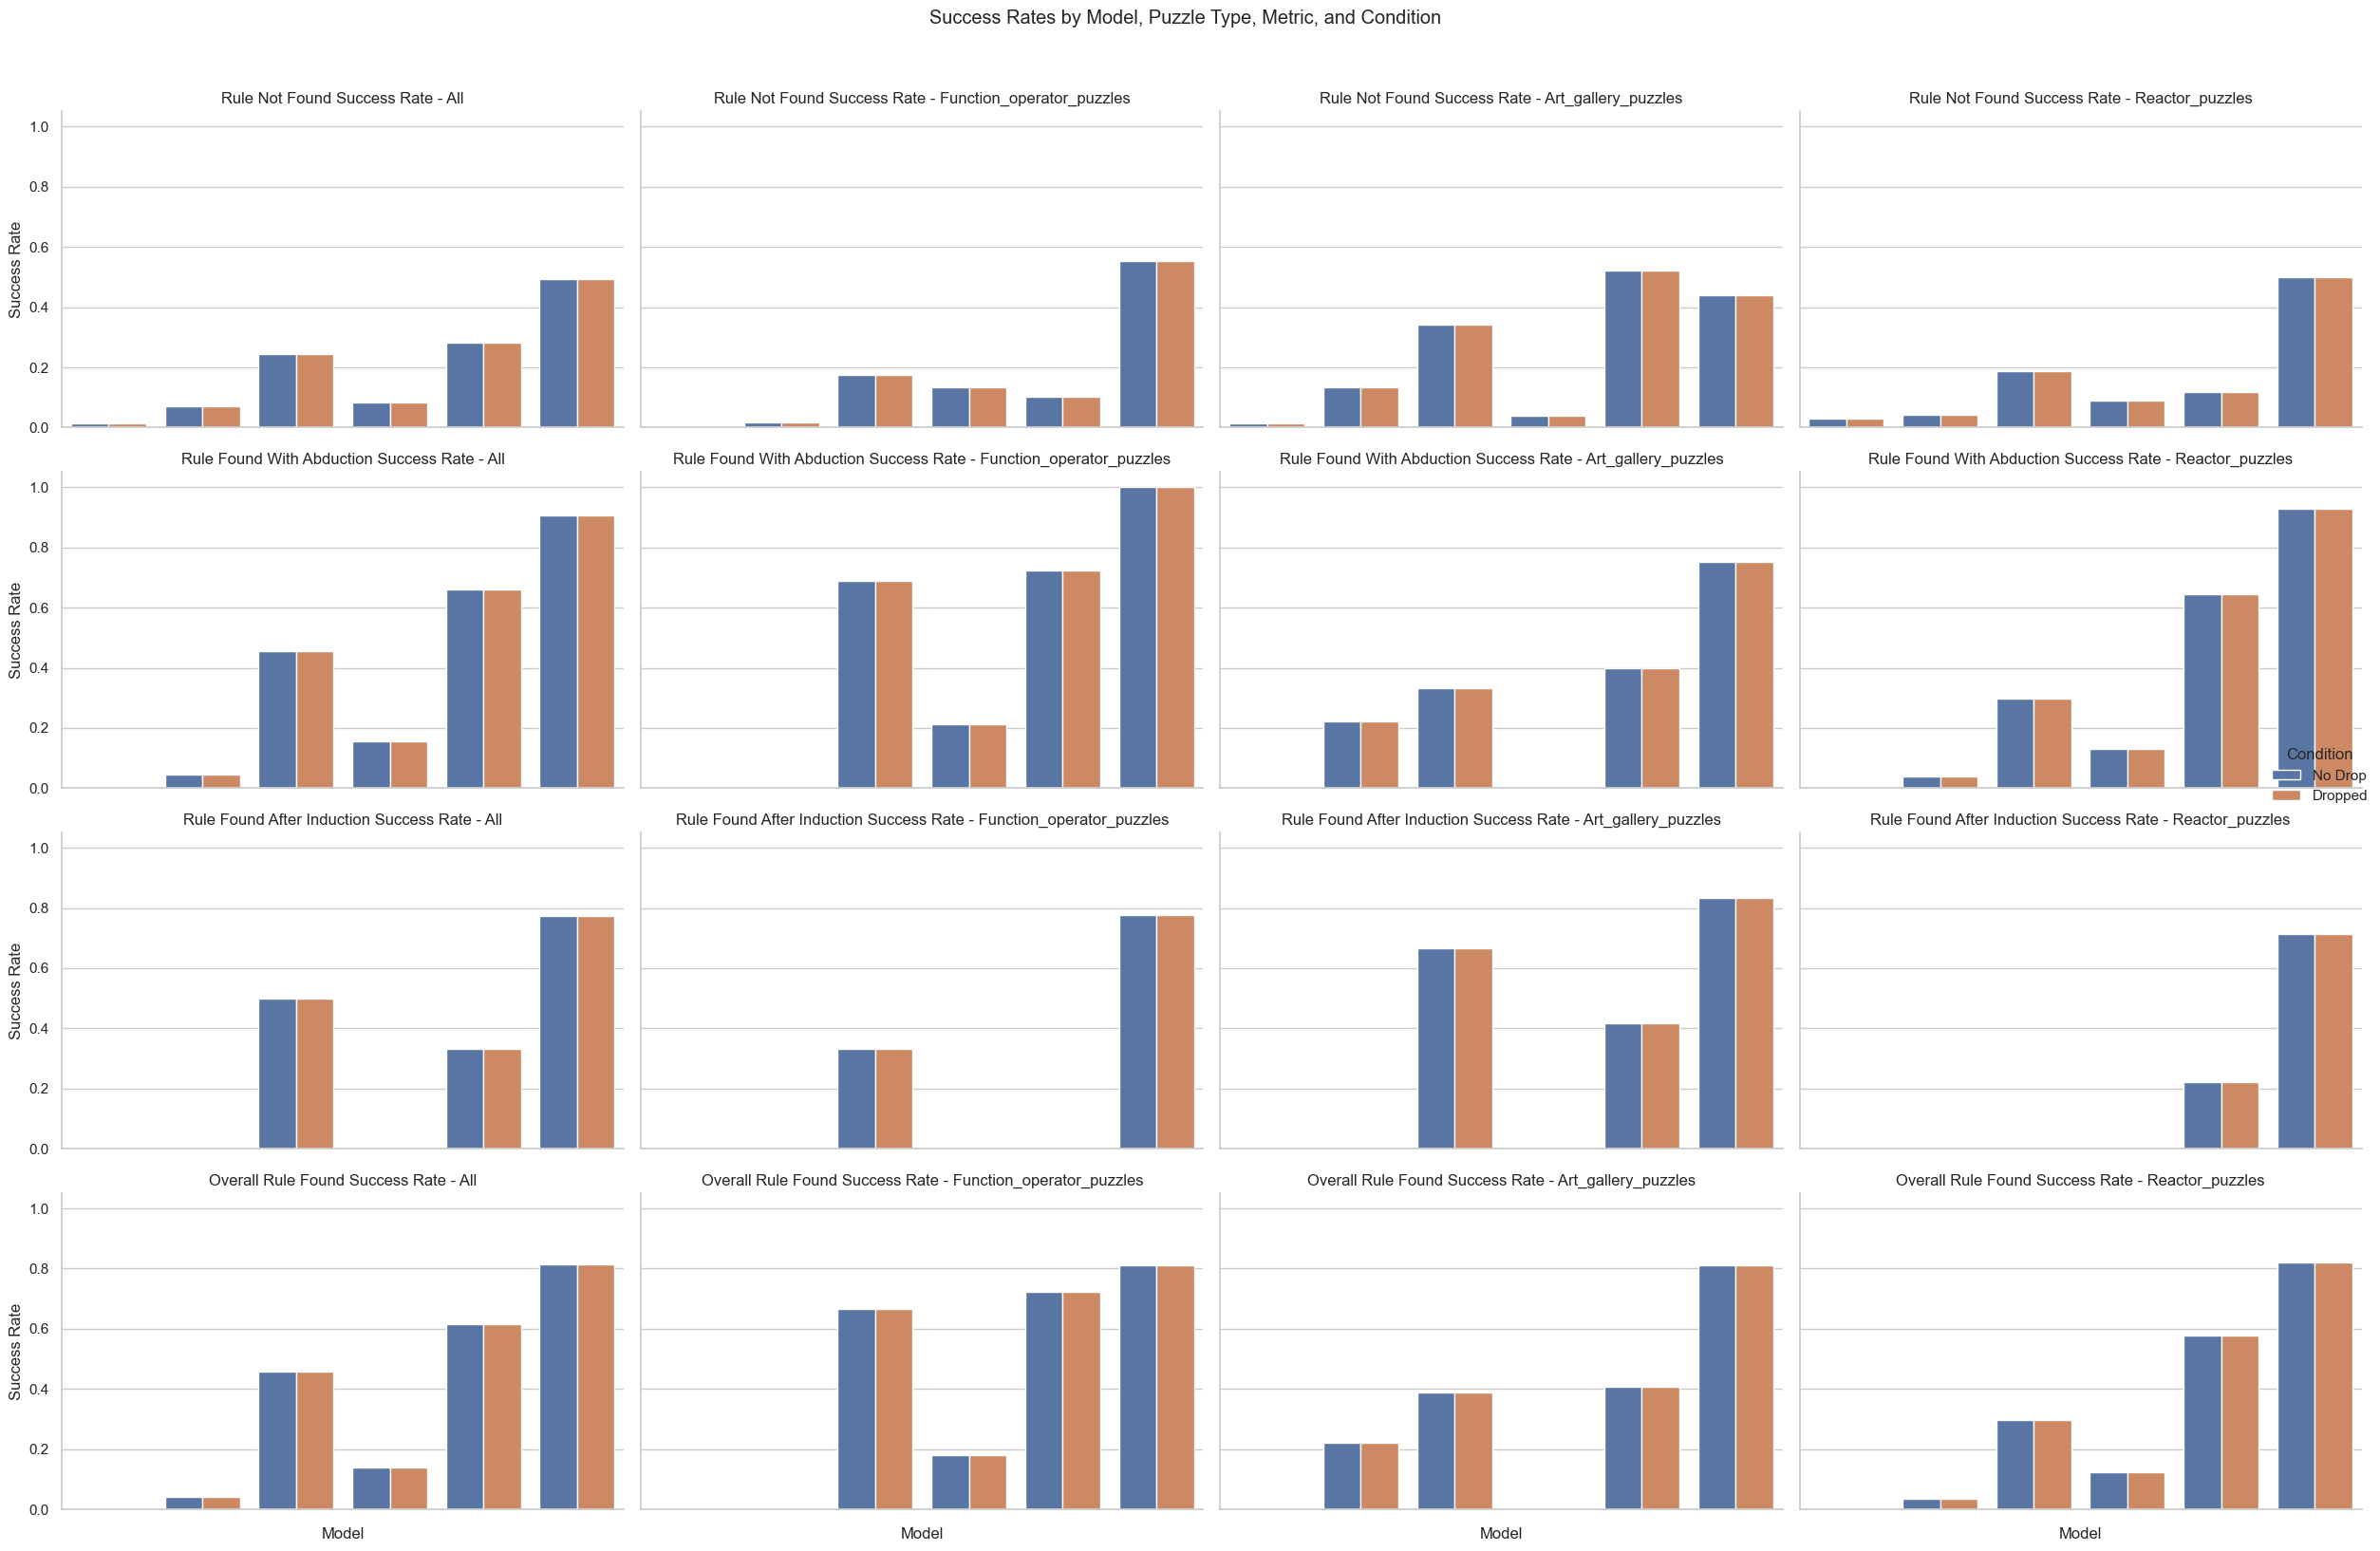

In [24]:
drop_data = get_success_rate_data(drop_puzzle_index=drop_puzzle_index)
no_drop_data = get_success_rate_data()
plot_success_rate_data_comparison(no_drop_data, drop_data)

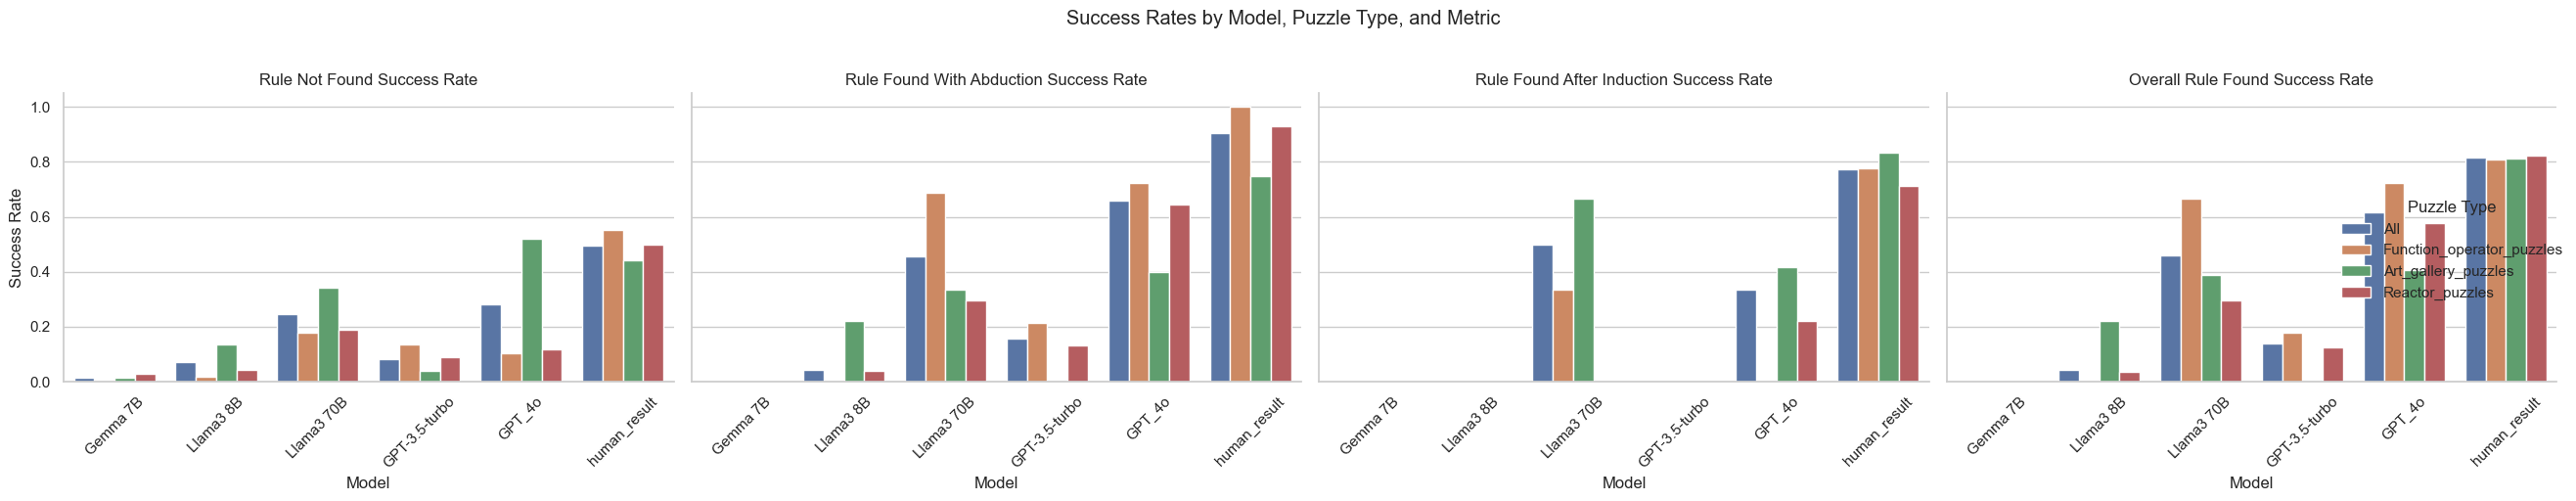

In [25]:
plot_success_rate_data(drop_data)

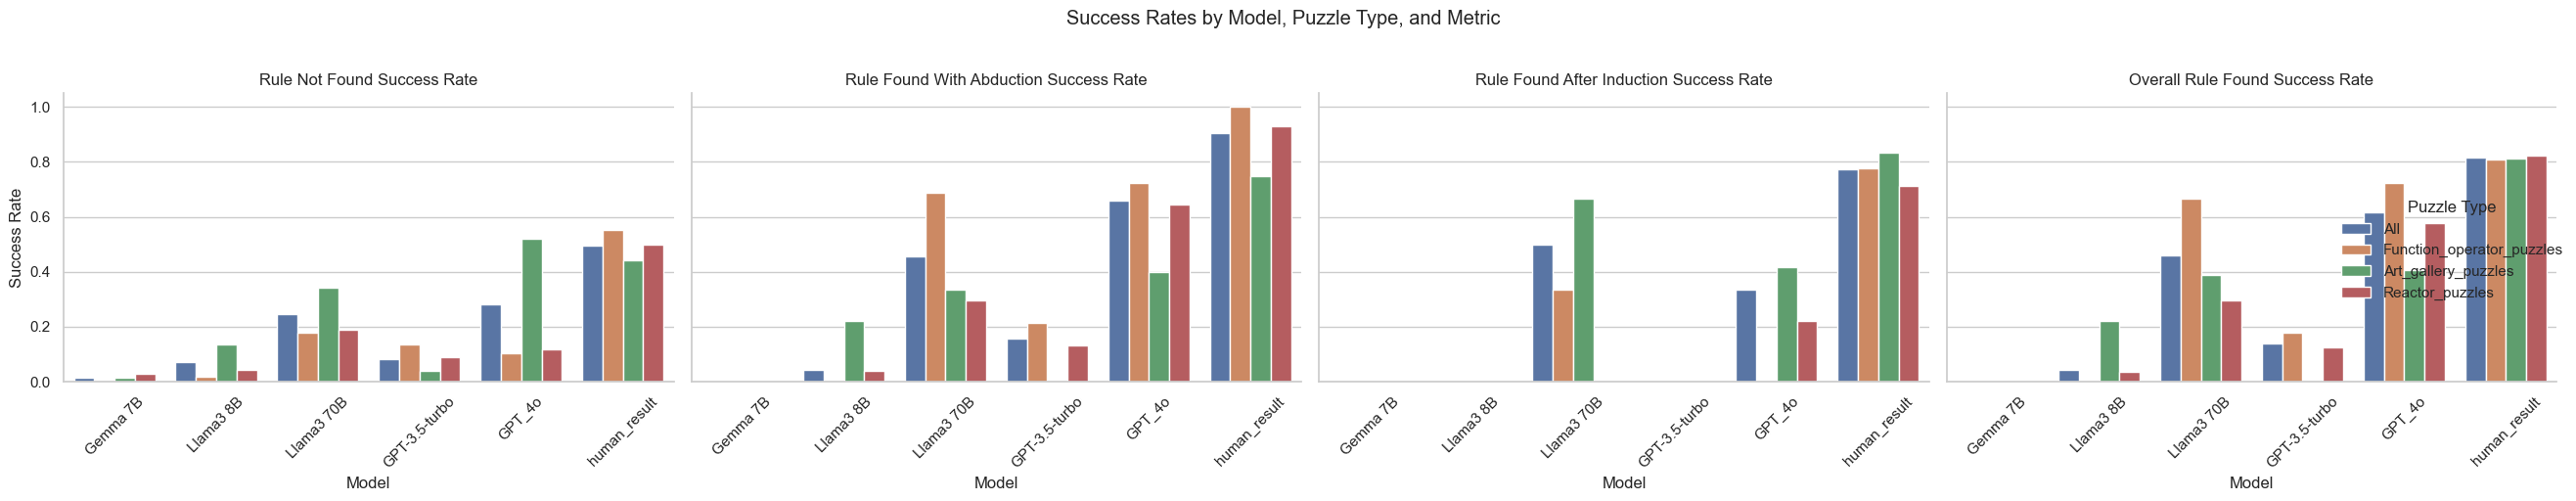

In [26]:
plot_success_rate_data(drop_data)